## ------------------------- Install Packages -------------------------------

In [1]:
!pip install pandas_datareader
!pip install googlefinance.client
!pip install more_itertools
!pip install pynance
!pip install alpha_vantage
!pip install fix_yahoo_finance
!pip install praw
!pip install vaderSentiment
!pip install flask
!pip install wtforms 

    100% |████████████████████████████████| 112kB 4.8MB/s 
    100% |████████████████████████████████| 5.8MB 5.7MB/s 
  Running setup.py bdist_wheel for requests-ftp ... - done
  Stored in directory: /root/.cache/pip/wheels/2a/98/32/37195e45a3392a73d9f65c488cbea30fe5bad76aaef4d6b020
Successfully built requests-ftp
    100% |████████████████████████████████| 61kB 3.8MB/s 
    100% |████████████████████████████████| 153kB 8.2MB/s 
  Running setup.py bdist_wheel for googlefinance.client ... - done
  Stored in directory: /root/.cache/pip/wheels/02/e8/0e/0393e88a796451109f34f5bc606492c775e1a0b1b3660fd5bc
  Running setup.py bdist_wheel for zope.interface ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/c6/b2/d2/be6785a207eaa58d76debc10c9d5c66196b40a88abb61d6af7
Successfully built googlefinance.client zope.interface
    100% |████████████████████████████████| 51kB 3.5MB/s 
  Running setup.py bdist_wheel for pynance ... - \ done
  Stored in directory: /root/.cache/pi

## ------------------------- Import Modules -------------------------------

In [2]:
import datetime
import numpy as np
import pandas as pd

pd.core.common.is_list_like = pd.api.types.is_list_like
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from pandas_datareader import data as pdr
from dateutil.relativedelta import relativedelta
from keras.layers.core import Dense, Activation, Dropout

import os
import pickle
import warnings
import numpy as np
import fix_yahoo_finance as yf
from scipy.signal import savgol_filter
from scipy.interpolate import splprep, splev
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")
yf.pdr_override()

Using TensorFlow backend.


##------------------------- Functions and Classes -------------------------

In [0]:
def go_back(s):
    '''
    Convert input of the type "#A" (i.e. "30d", "2w", "10m", 1y", etc) to a
    datetime object corresponding to the date going back the input time span.
    '''
    dict = {'d': 'days', 'w': 'weeks', 'm': 'months', 'y': 'years'}

    if s[-1] in ['d', 'D', 'days']:
        date = datetime.now() - relativedelta(days=int(s[:-1]))
    elif s[-1] in ['w', 'W', 'weeks']:
        date = datetime.now() - relativedelta(weeks=int(s[:-1]))
    elif s[-1] in ['m', 'M', 'months']:
        date = datetime.now() - relativedelta(months=int(s[:-1]))
    elif s[-1] in ['y', 'Y', 'years']:
        date = datetime.now() - relativedelta(years=int(s[:-1]))
    else:
        raise ValueError('Date has to be of the form \'45d\'')

    return date


class Stock:
    '''
    Stock class scrapes daily stock price information from Yahoo Finance.
    The data includes Open, Low, High, Close prices, and Volume.
    '''
    def __init__(self, stock='GOOG', start='1y', end='0d'):
        self.stock = stock
        self.start = go_back(start).strftime('%Y-%m-%d')
        self.end = go_back(end).strftime('%Y-%m-%d')
        self.success = False

        try:
            self.data = pdr.get_data_yahoo(stock, start=self.start, end=self.end)
            self.success = True
        except ValueError:
            print('Yahoo finance be deadz :(')
        if self.success:
            del self.data.index.name
            self.data.drop(['Adj Close'], axis=1, inplace=True)


def unroll(data, window=25):
    '''
    Unrolls data into window-size slices offset by 1.
    Ex: unroll([1,2,3,4], 2) returns [[1,2], [2,3], [3,4]]
    '''
    slices = []
    for i in range(len(data) - window):
        slices.append(data[i: i + window])
    return np.array(slices)


def prepare_data(data, scaler, split=0.75, window=25):
    '''
    Data is split into training and test sets, scaled, and unrolled.
    '''
    split = int(split * len(data))
    cols = list(data.columns)[:-1]

    train_data = data[:split].copy()
    test_data = data[split - window:].copy()

    scaler.fit(train_data)
    scaled_train_data = scaler.transform(train_data)
    scaled_test_data = scaler.transform(test_data)

    X_train = np.array(scaled_train_data[:, :-1])
    y_train = np.array(scaled_train_data[:, -1])
    X_test = np.array(scaled_test_data[:, :-1])
    y_test = np.array(scaled_test_data[:, -1])

    X_train = unroll(X_train, window)
    y_train = y_train[-X_train.shape[0]:]
    X_test = unroll(X_test, window)
    y_test = y_test[-X_test.shape[0]:]

    return train_data, \
           test_data, \
           scaled_train_data, \
           scaled_test_data, \
           X_train, \
           y_train, \
           X_test, \
           y_test


def create_model(X_train, model_name='LSTM', window=25, activation='linear', time_ahead=1):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(window, input_shape=(None, X_train.shape[-1])))
    #         model.add(Dropout(0.2))
    #         model.add(LSTM(128, return_sequences = False))
    #         model.add(Dropout(0.2))
    elif model_name == 'BiLSTM':
        model.add(Bidirectional(LSTM(window), input_shape=(None, X_train.shape[-1])))
    elif model_name == 'GRU':
        model.add(GRU(window, input_shape=(None, X_train.shape[-1])))
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model


def rescale(scaler, window,
            scaled_train_data, scaled_test_data,
            train_predictions, test_predictions):
    '''
    Data is scaled back to its original range for plotting and trading
    '''
    # skip the first window # of points since there are no predictions
    # made in that time period and rescale
    joined_trained = np.hstack((np.array(scaled_train_data[window:, :-1]), train_predictions))
    joined_test = np.hstack((np.array(scaled_test_data[window:, :-1]), test_predictions))
    train_y_hat = scaler.inverse_transform(joined_trained)[:, -1]
    test_y_hat = scaler.inverse_transform(joined_test)[:, -1]

    return train_y_hat, test_y_hat


def plot_prediction(stock, prediction, train_data, test_data, train_y_hat, test_y_hat,
                    y_train, window, xC):
    '''
    Training and test data and their predictions are plotting on the same figure.
    A plot of actual prices or of the change in stock movement direction (+-1)
    can be displayed.
    '''
    plt.figure(figsize=(15, 8))

    if prediction == 'price':
        c = stock.data['Close'][window:].values
#         original = c[window:]
        split = len(train_data)
        # filler of empty values is used to offset and align data on the plot
        filler = [np.nan] * len(y_train)

        plt.fill_between(range(window - 1, len(c) + window - 1), c, color="grey",
                         alpha=0.3, label=str(stock.stock) + ' Close')

        plt.plot(xC[window:split], np.array(train_data.as_matrix()[window:, -1]),
                 'orange', label='y_train')
        plt.plot(xC[window:split], train_y_hat,
                 'green', label='y_train predicted')
        plt.plot(xC[window:-1], filler + list(test_data.as_matrix()[window:-1, -1]),
                 'red', label='y_test')
        plt.plot(xC[window:], filler + list(test_y_hat),
                 'blue', label='y_test predicted')

    # elif prediction == 'change':
    #
    #     trainS = np.cumsum(train_data.as_matrix()[window:])
    #     testS = np.cumsum(test_data.as_matrix()[window:])
    #     trainSP = np.round(np.cumsum(train_y_hat))
    #     testSP = np.round(np.cumsum(test_y_hat))
    #
    #     plt.plot(trainS, 'g', label='y_train')
    #     plt.plot(trainSP, 'orange', label='y_train predicted')
    #     plt.plot(([np.nan] * len(y_train)) + list(i + trainS[-1] for i in testS), 'b', label='y_test')
    #     plt.plot(([np.nan] * len(y_train)) + list(i + trainSP[-1] for i in testSP), 'r', label='y_test predicted')

    plt.axis([window - 1, len(c) + window - 1, np.min(c), np.max(c)])

    plt.legend(loc=0, fontsize=15)
    plt.tight_layout()
    plt.show()
    


def trade(stock, test_y_hat, munniez, shares, buy, sell, notes=False):
    # initial values
    m0 = munniez
    s0 = shares
    predicted = test_y_hat

    # Open and Close values for test time period
    o = np.array(stock.data['Open'].values)[-len(predicted) + 1:].copy()
    c = np.array(stock.data['Close'].values)[-len(predicted) + 1:].copy()
    dates = stock.data.index[-len(predicted) + 1:]

    #     predicted = pd.ewma(data['Tomorrow'][-len(test_y_hat):].copy().values, 3)
    #     predicted = data['Tomorrow'][-len(test_y_hat):].copy().values

    equity = [round(munniez + shares * c[0], 2)]

    history = [0]

    def show_notes(act, i):

        if act == 'buy':
            s = '  Bought %d for $%.2f' % (bought, round(o[i], 2))
        elif act == 'sell':
            s = '  Sold  %d for $%.2f ' % (sold, round(o[i], 2))
        else:
            s = '  ------- Hodl ------ '

        print(dates[i - 1].date(),
              'Predicted Today: $%.2f' % predicted[i],
              '  Predicted Yesterday: $%.2f' % predicted[i - 1], s,
              '   Closed $%.2f' % c[i],
              '  Equity $%.2f' % (munniez + shares * c[i]))

    for i in range(1, len(predicted) - 1):
        hold = True
        # buy some if today is predicted to close higher
        if predicted[i] > predicted[i - 1]:
            if munniez * buy >= o[i]:
                history.append(1)
                hold = False
                bought = munniez * buy // o[i]
                munniez -= o[i] * bought
                munniez = round(munniez, 2)
                shares += bought
                if notes:
                    show_notes('buy', i)

        # sell some if today is predicted to close lower
        elif predicted[i] < predicted[i - 1]:
            if shares > 0:
                history.append(-1)
                hold = False
                sold = int(shares * sell)
                munniez += sold * o[i]
                shares -= sold
                if notes:
                    show_notes('sell', i)

        if hold:
            history.append(0)
            if notes:
                show_notes('hold', i)

        equity.append(round(munniez + shares * c[i], 2))

    if predicted[-1] > predicted[-2]:
        tomorrow = 'Buy'
    else:
        tomorrow = 'Sell'

    i = (m0 + s0 * c[0])
    f = (m0 + s0 * c[-1])
    hold_change = 'Hold: {:.2%}'.format((f - i) / i)
    trade_change = 'Trade: {:.2%}'.format((equity[-1] - equity[0]) / equity[0])
    print(hold_change)
    print(trade_change)
    print('Today is', dates[-1].date())
    print(stock.stock + ' is a', tomorrow)

    fig, ax1 = plt.subplots(figsize=(15, 7))
    # msg = ' with starting balance $%.2f, %d shares' % (m0, s0)
    fig.suptitle(str(stock.stock), fontsize=25, color='cornflowerblue')

    ax1.fill_between(range(len(c)), c, color="cornflowerblue", alpha=0.2)
    # ax1.plot(c, 'cornflowerblue', alpha=0.5)
    ax1.set_ylabel('Prediction', color='b', fontsize=20)
    #     ax1.set_xticklabels([d.date() for d in dates])
    ax1.tick_params('y', colors='b')
    ax1.set_xlim([0, len(c)])
    ax1.set_ylim([min([min(c), min(predicted)]), max([max(c), max(predicted)])])

    ax1.plot(predicted, 'b')
    ax1.plot(o, 'b', linewidth=0.5, linestyle=":", dashes=(5, 10))

    ax2 = ax1.twinx()
    ax2.plot(equity, 'r')
    ax2.set_ylabel('Equity', color='r', fontsize=20)
    ax2.tick_params('y', colors='r')

    ax1.grid(False)
    ax2.grid(zorder=0)
    ax2.grid(color='grey', linestyle=':', linewidth=1, alpha = 0.5)
    ax2.set_axisbelow(True)

    # mark where selling and buying
    for i in range(len(history)):
        if history[i] > 0:
            ax1.axvline(x=i, color='green', linewidth=1)
        elif history[i] < 0:
            ax1.axvline(x=i, color='red', linewidth=1)

    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    plt.show()

    return tomorrow, hold_change, trade_change


## ------------------------- Run code -------------------------

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

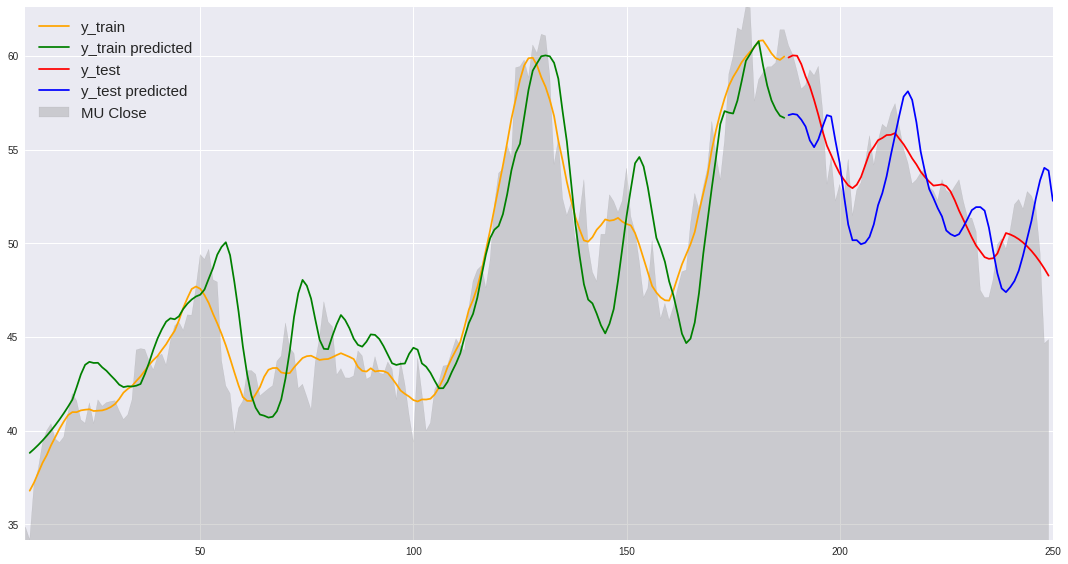

Hold: -9.77%
Trade: -24.92%
Today is 2018-09-07
MU is a Sell


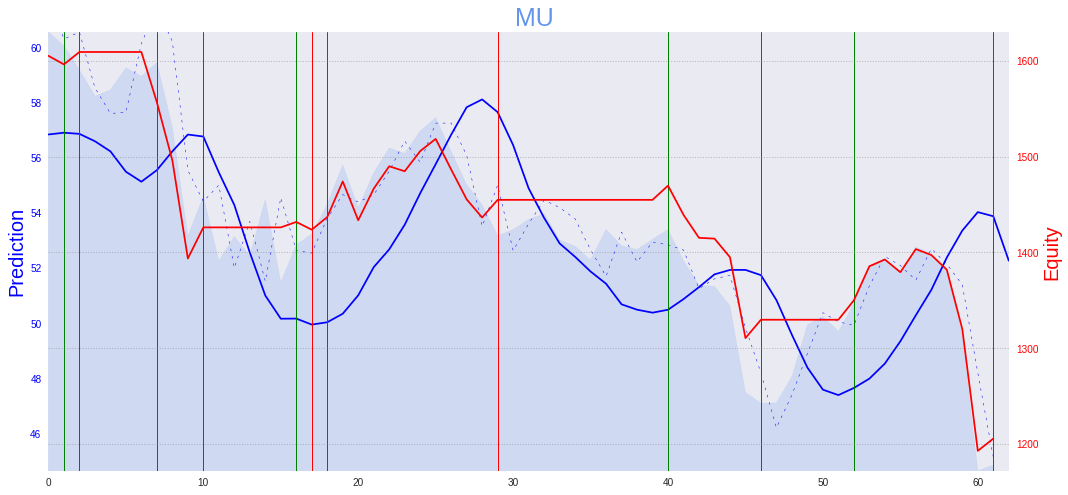

In [4]:

np.random.seed(8)


window = 10
split = 0.75
epochs = 30
batch_size = 1

# Initialize portfolio
munniez = 1000
shares = 10
buy = 1
sell = 1

# initialize a portfolio and create a stock for each with the corresponding variable name
portfolio = ['MU', 'WB', 'AMZN', 'GOOG', 'CRSP', 'FB', 'GOOGL', 'BABA', 'PSTG',
            'EA', 'CRM', 'BZUN', 'MOMO', 'LRCX', 'NFLX', 'AABA', 'GDDY', 'MSFT',
            'SEDG', 'BIDU']
# for s in portfolio:
#   exec(s + " = Stock(s, start = '1y')")

stock = MU
data = stock.data.copy()

# ---------------------------- smoothing function ------------------------------
def smoothed(price, fit):
    x = range(len(data[price]))
    y = data[price].values

    if fit == 'spline':
        tck, _ = splprep([x, y])
        x2, y2 = splev(np.linspace(0, 1, len(y)), tck)

    elif fit == 'savgol':
        x2 = x
        y2 = savgol_filter(y, 21, 2, mode='interp')

    return x2, y2

# xO, data['Open Smoothed'] = smoothed('Open', 'spline')
# xC, data['Close Smoothed'] = smoothed('Close', 'spline')

xO, data['Open Smoothed'] = smoothed('Open', 'savgol')
xC, data['Close Smoothed'] = smoothed('Close', 'savgol')

w = 21
c = stock.data['Close'].values
p = list(savgol_filter(c[:w], w, 2, mode = 'interp'))

for i in range(w, len(data)):
  
    pts = savgol_filter(c[:i], w, 2, mode = 'interp')
    z = np.polyfit(range(i-20,i), pts[-20:], 3)
    f = np.poly1d(z)
    p.append(f(i+2))
    
p.append(f(len(data) + 3))    
print(len(data), len(p))    
data['Kinda Smooth'] = p[1:]


# ------------------------------------------------------------------------------


# Predict tomorrow's closing price
data['EWMA 3'] = pd.ewma(data['Close'], 3)
data['EWMA 5'] = pd.ewma(data['Close'], 25)
data['Tomorrow'] = data['Close Smoothed'].shift(-1)
# data['Tomorrow'] = data['Close Smoothed'].shift(-1)

# Columns to keep
data = data[['Kinda Smooth', 'Tomorrow']]
# data = data[['Close', 'Kinda Smooth', 'Tomorrow']]

# tomorrow_predict_data = data.iloc[-window - 2:]
# data.dropna(inplace = True)
data.fillna(method='ffill', inplace=True)

# Shift the column to be predicted to the end
data = data[list(data.columns.drop('Tomorrow')) + ['Tomorrow']]

# Get training and test data
scaler = MinMaxScaler()

train_data, test_data, \
scaled_train_data, scaled_test_data, \
X_train, y_train, X_test, y_test = prepare_data(data, scaler, split, window)

print('Data shape: ', data.shape)
print('Train data : ', train_data.shape)
print('Test data : ', test_data.shape)
print('X_train :', X_train.shape)
print('y_train :', y_train.shape)
print('X_test  :', X_test.shape)
print('y_test  :', y_test.shape)
print()

# Create model
model = create_model(X_train, 'LSTM', window, 1)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Get predictions
train_predictions = model.predict(X_train, batch_size=batch_size)
test_predictions = model.predict(X_test, batch_size=batch_size)

# Rescale data back
train_y_hat, test_y_hat = rescale(scaler, window,
                                  scaled_train_data, scaled_test_data,
                                  train_predictions, test_predictions)

# Plot predictions
plot_prediction(stock, 'price', train_data, test_data, train_y_hat,
                test_y_hat, y_train, window, xC)

# Trade
tomorrow, hold_change, trade_change = trade(stock, test_y_hat, munniez, shares, buy, sell)

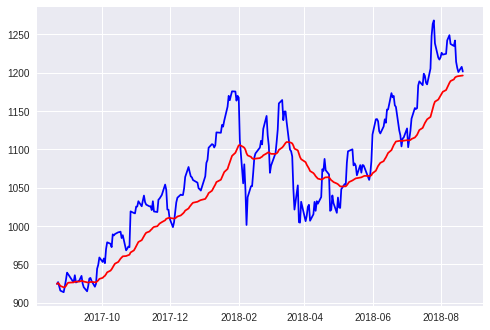

In [140]:
plt.plot(stock.data['Close'], 'b')
plt.plot(pd.ewma(stock.data['Close'], 20), 'r')
plt.show()

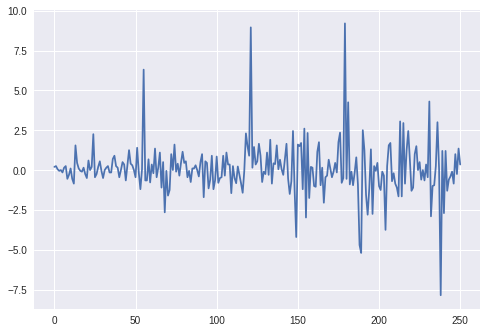

ADF Statistic: -1.638954
p-value: 0.462807
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [21]:
l = list(SEDG.data['Close'].values)
diff = []

for i in range(len(l)-1):
  diff.append(l[i+1] - l[i])
  
plt.plot(diff)
plt.show()

from random import seed
from random import random
from statsmodels.tsa.stattools import adfuller

'''
By conducting an Augmented Dickey Fuller test we can check if the series
is stationary. If ADF Statistic is less than critical value, H0 is rejected
and we conclude that the series is stationary (value are not dependent on time).
'''
result = adfuller(l)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

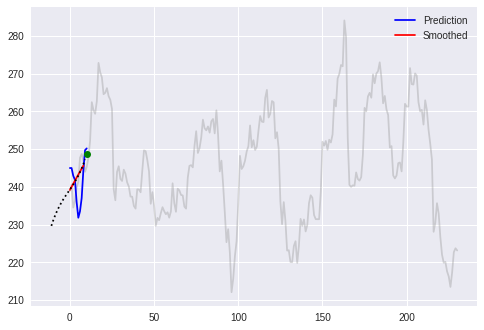

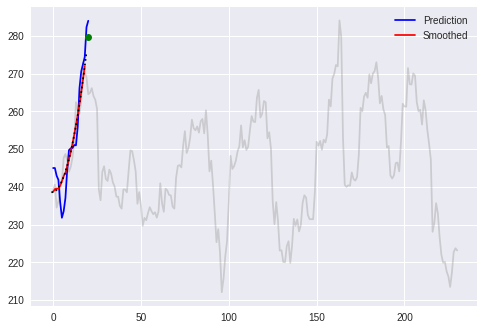

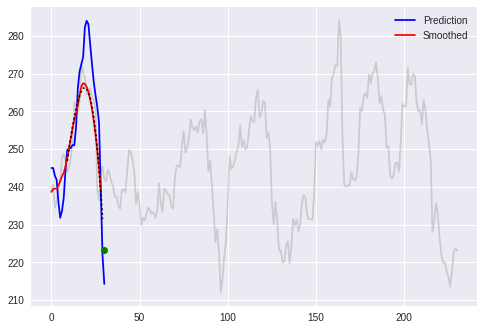

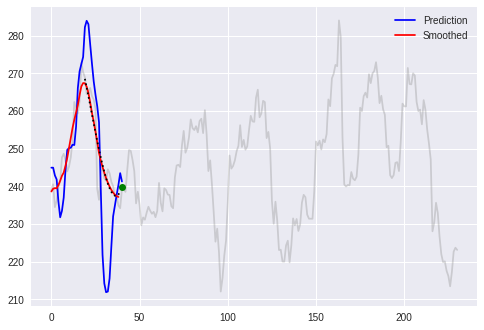

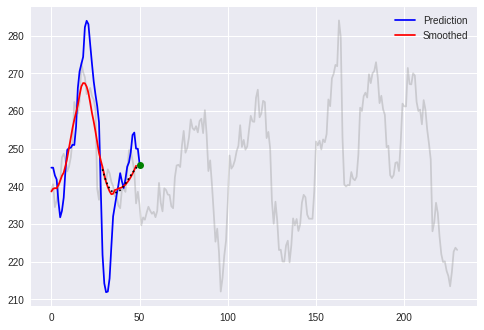

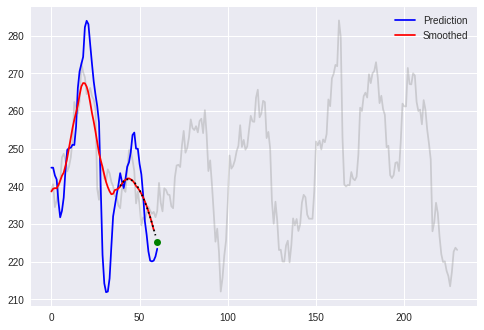

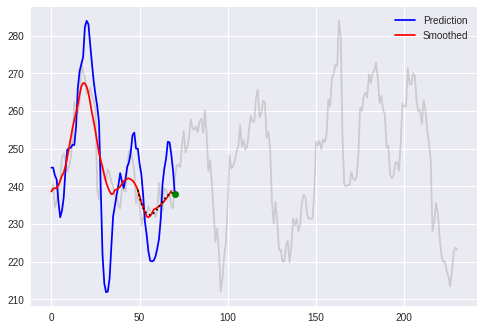

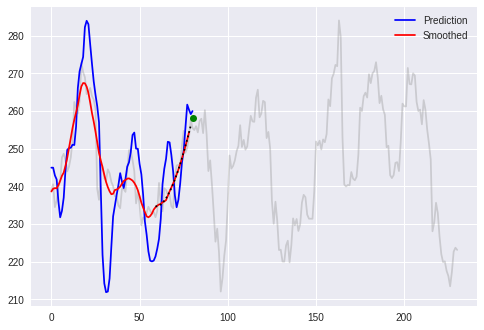

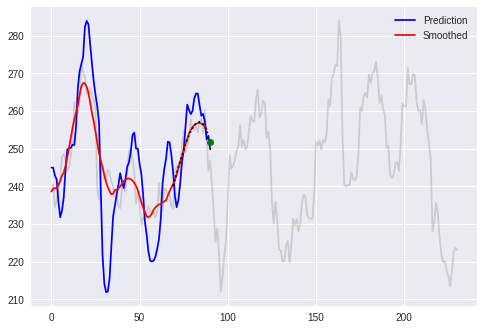

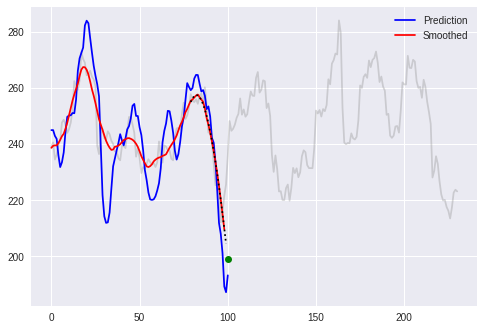

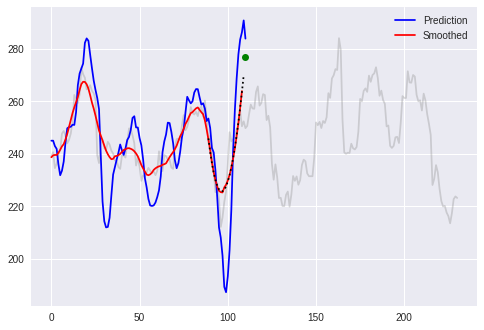

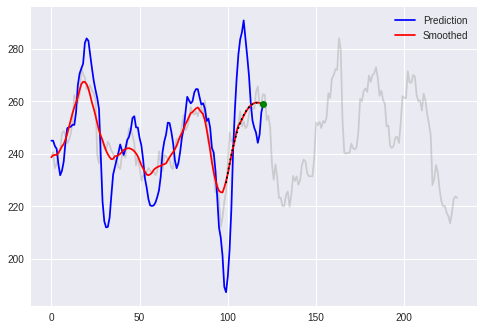

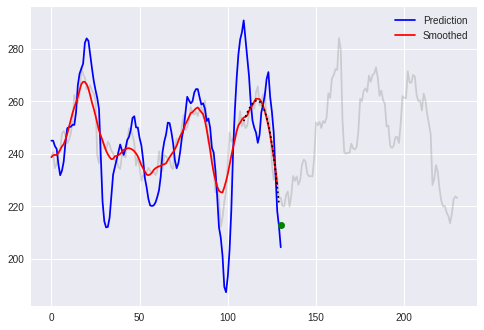

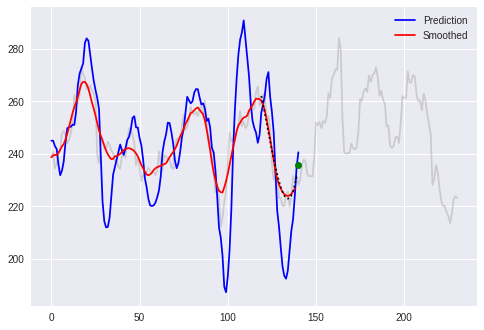

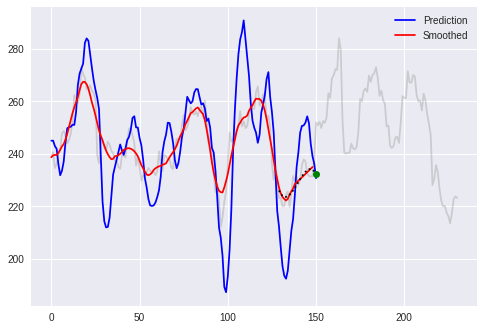

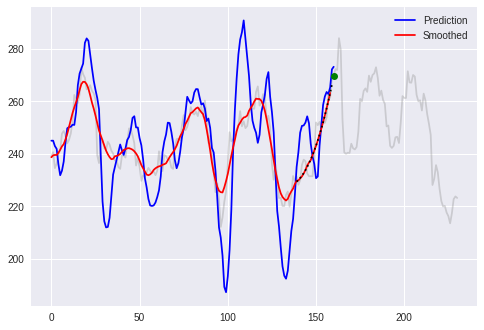

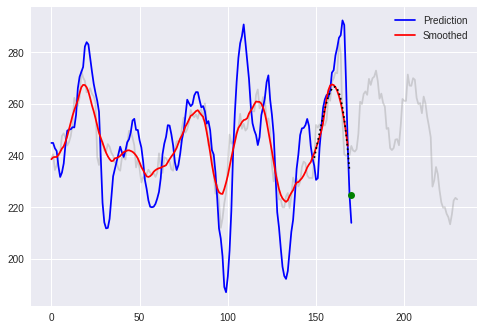

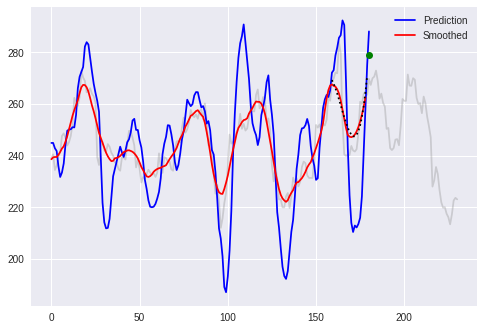

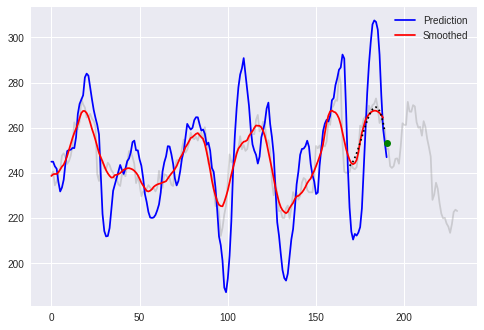

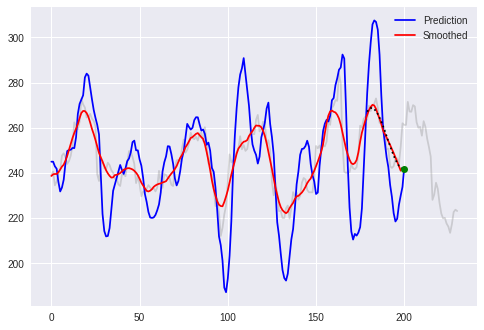

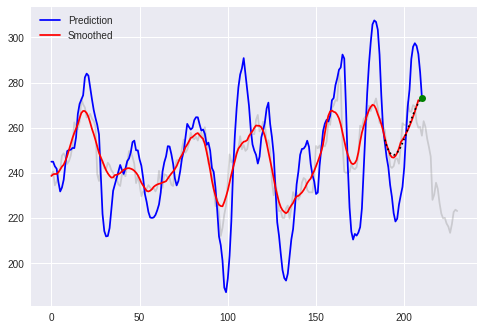

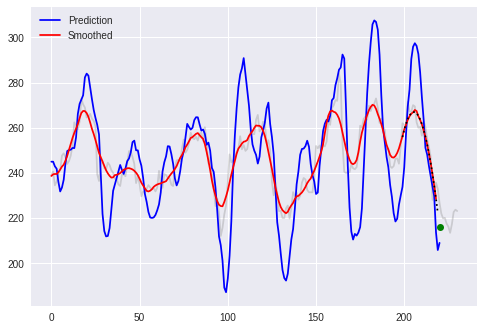

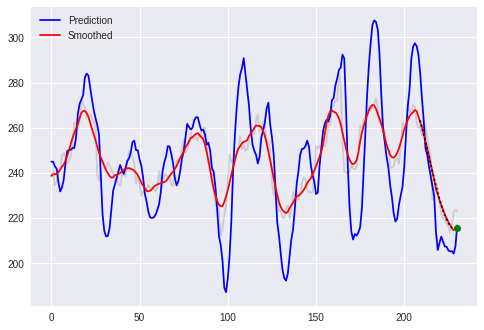

252 231


[]

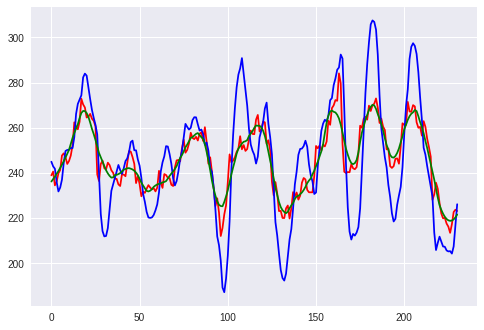

In [76]:
w = 21
c = stock.data['Close'].values
p = []

for i in range(w, len(data)):
  
    pts = savgol_filter(c[:i], w, 2, mode = 'interp')
    z = np.polyfit(range(i-20,i), pts[-20:], 3)
    f = np.poly1d(z)
    p.append(f(i+2))
    if i%10 == 0:
        plt.plot(c[w:], 'grey', alpha = 0.3 )
        plt.plot([p[0]] + p, 'b', label = 'Prediction')
        plt.plot(pts[w:], 'r', label = 'Smoothed')
        plt.plot(range(i-20-w,i-w+1), f(range(i-20,i+1)), 'black', linestyle = ':')
        plt.plot(i+1-w, f(i+1), 'go')
        plt.legend(loc=0)
        plt.show()

print(len(c), len(p))
plt.plot(stock.data['Close'][w:].values, 'r')
plt.plot(p, 'b')
plt.plot(savgol_filter(stock.data['Close'].values[w:], w, 2, mode = 'interp'), 'g')
plt.plot()


In [0]:
# !pip install -U textblob
# !python -m textblob.download_corpora
# !pip install tweepy

#Import tweepy
import tweepy

#Define 4 variables for authenticating with Twitter
#Each student will have their own unique tokens
consumer_key = 'insert key here'
consumer_secret= 'insert secret here'
access_token = 'insert token here'
access_token_secret = 'insert token here'

#Autenticate with Twitter
authen = tweepy.OAuthHandler(consumer_key, consumer_secret)
authen.set_access_token(access_token, access_token_secret)

In [14]:
#Test drive TextBlob
from textblob import TextBlob

#Initialize a variable
txtblob = TextBlob("Lambda School is awesome.")

#Get the POS
txtblob.tags

#Tokenize the text
txtblob.words

#Examine the polarity of the sentiment expressed in the text
#It is a positive statement
txtblob.sentiment.polarity

#Get a connection to Twitter
tweetapi = tweepy.API(authen)

@angela_donlan Think of nothing, if you can. It’s not easy but once you have switch off the flood gates to your ima… https://t.co/lundQ6i3iJ
Sentiment(polarity=-0.21666666666666667, subjectivity=0.8333333333333334)
RT @quendergeer: I am fucking losing it at this cartoon of McCain preparing to napalm the pearly gates https://t.co/n61VOYHtyi
Sentiment(polarity=-0.6, subjectivity=0.8)
RT @amoneybroden: daily reminder i still love kevin gates.
Sentiment(polarity=0.25, subjectivity=0.3)
'And I myself I will carry you to the gates of Mortoxia. You will fight eternal, bloody and mute'
Sentiment(polarity=-0.8, subjectivity=0.9)
RT @amitbhawani: @UnboxTherapy @tim_cook Retweeted, the Gates will open sooner or later. 😉
Sentiment(polarity=0.0, subjectivity=0.25)
Looking forward to doing a fun @fightingfantasy double act with @monstroso at @Bathfestivals on 29th September talk… https://t.co/K5BmFvkDoh
Sentiment(polarity=0.15, subjectivity=0.1)
Open the flood gates this love-hate is making me cry
S

In [17]:
#This method is going to return tweets that contain the word 
visible_public_tweets = tweetapi.search('Facebook')

#Iterate through the tweets that have been retrieved
#Examine the polarity (positive or negative the tweet is) and the subjectivity (how much of an opinion it is)

for tweet in visible_public_tweets:
    print(tweet.text)
    sentimentAnalyzer = TextBlob(tweet.text)
    print(sentimentAnalyzer.sentiment)
    print('-'*80)

https://t.co/Ex9w7rdTGN
Sentiment(polarity=0.0, subjectivity=0.0)
--------------------------------------------------------------------------------
RT @WORLDMUSICAWARD: #LadyGaga makes Superstar arrival at the #VeniceFilmFestival where her movie, #AStarIsBorn will premiere tomorrow!👩‍🎤…
Sentiment(polarity=0.0, subjectivity=0.0)
--------------------------------------------------------------------------------
Solangel Gálvez E https://t.co/jsJdWT7MJL
Sentiment(polarity=0.0, subjectivity=0.0)
--------------------------------------------------------------------------------
https://t.co/GUJOWflLeO
Sentiment(polarity=0.0, subjectivity=0.0)
--------------------------------------------------------------------------------
https://t.co/YSQSS4TjBy
Sentiment(polarity=0.0, subjectivity=0.0)
--------------------------------------------------------------------------------
https://t.co/xuuDoZyBnu
Sentiment(polarity=0.0, subjectivity=0.0)
-----------------------------------------------------------------

In [43]:
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob
 
class TwitterClient(object):
    '''
    Generic Twitter Class for sentiment analysis.
    '''
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
        # keys and tokens from the Twitter Dev Console
        
        consumer_key = 'insert key here'
        consumer_secret= 'insert secret here'
        access_token = 'insert token here'
        access_token_secret = 'insert token here'

 
        # attempt authentication
        try:
            # create OAuthHandler object
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            # set access token and secret
            self.auth.set_access_token(access_token, access_token_secret)
            # create tweepy API object to fetch tweets
            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")
 
    def clean_tweet(self, tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
 
    def get_tweet_sentiment(self, tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(self.clean_tweet(tweet))
        # set sentiment
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
 
    def get_tweets(self, query, count = 10):
        '''
        Main function to fetch tweets and parse them.
        '''
        # empty list to store parsed tweets
        tweets = []
 
        try:
            # call twitter api to fetch tweets
            fetched_tweets = self.api.search(q = query, count = count)
 
            # parsing tweets one by one
            for tweet in fetched_tweets:
                # empty dictionary to store required params of a tweet
                parsed_tweet = {}
 
                # saving text of tweet
                parsed_tweet['text'] = tweet.text
                # saving sentiment of tweet
                parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text)
 
                # appending parsed tweet to tweets list
                if tweet.retweet_count > 0:
                    # if tweet has retweets, ensure that it is appended only once
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                else:
                    tweets.append(parsed_tweet)
 
            # return parsed tweets
            return tweets
 
        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))
 
def get_sentiment(query):
    # creating object of TwitterClient Class
    api = TwitterClient()
    # calling function to get tweets
    tweets = api.get_tweets(query = query, count = 200)
    tweets = [t for t in tweets if t['text'].count('$') < 2]
 
    # picking positive tweets from tweets
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
    # percentage of positive tweets
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets)))
    # picking negative tweets from tweets
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
    # percentage of negative tweets
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets)))
    # percentage of neutral tweets
    print("Neutral tweets percentage: {} % \
        ".format(100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets)))
 
    # printing first 5 positive tweets
    print("\n\nPositive tweets:")
    for tweet in ptweets[:10]:
        print(tweet['text'])
 
    # printing first 5 negative tweets
    print("\n\nNegative tweets:")
    for tweet in ntweets[:10]:
        print(tweet['text'])
                               
get_sentiment('$BABA')

Positive tweets percentage: 26.19047619047619 %
Negative tweets percentage: 7.142857142857143 %
Neutral tweets percentage: 66.66666666666667 %         


Positive tweets:
$BABA burn the nonbelievers LOL. If this was an unprofitable,  no growth name in a country in recession i'd understand. NOT the case #stocks
$BABA 177.77
In the repeated plunge mode since it hit a new high of 211.70. 1st plunge 205-201, 2nd 202-196, 3rd 19… https://t.co/JOL6cd3Yp2
Fascinating article. $BABA and others are schemes for Chinese to suck money out of US investors...

https://t.co/RR3bA4rkKN
136% return on BABA this morning! Not a crazy profit but for a 100+% return on a 8 minute trade, not bad! $AAPL… https://t.co/VQnfwkjpYC
@art2i Ghost own 30 or 40% of the company being taken over first. Or punk some US investors with a shell listing, t… https://t.co/4f2fAi9gN0
Why would $BABA even screw around in the US trying to build their cloud biz when so much greenfield opp in SE Asia… https://t.co/HXt7Vyd5fJ
Try o

In [40]:
# !pip install searchtweets
# from searchtweets import ResultStream, gen_rule_payload, load_credentials
# premium_search_args = load_credentials("~/.twitter_keys.yaml",
#                                        yaml_key="search_tweets_premium",
#                                        env_overwrite=False)

search_tweets_api:
  account_type: premium
  endpoint: <FULL_URL_OF_ENDPOINT>
  consumer_key : <'''insert key here'''>
  consumer_secret : <'''insert secret here'''>

SyntaxError: ignored

#--------------------- OTHER RANDOM IRRELEVANT STUFF BELOW ---------------------------------------------------------------------------------------------------------------

## YAHOO

In [0]:
# ---------------------------- YAHOO --------------------------


from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta

today = datetime.today().strftime('%Y-%m-%d')
last_year = datetime.now() - relativedelta(years=1)
last_year = last_year.strftime('%Y-%m-%d')
yf.pdr_override()

def go_back(s):
  dict = {'d': 'days', 'w': 'weeks', 'm': 'months', 'y': 'years'}
  
  if s[-1] in ['d', 'D', 'days']: date = datetime.now() - relativedelta(days = int(s[:-1]))
  elif s[-1] in ['w', 'W', 'weeks']: date = datetime.now() - relativedelta(weeks = int(s[:-1]))
  elif s[-1] in ['m', 'M', 'months']: date = datetime.now() - relativedelta(months = int(s[:-1]))
  elif s[-1] in ['y', 'Y', 'years']: date = datetime.now() - relativedelta(years = int(s[:-1]))
  else: raise ValueError('Date has to be of the form \'45d\'')
  
  return date

class Stock:
  def __init__(self, stock = 'GOOG', start = '1y', end = '0d'):

    self.stock = stock
    self.start = go_back(start).strftime('%Y-%m-%d')
    self.end = go_back(end).strftime('%Y-%m-%d')

    self.data = pdr.get_data_yahoo(stock, start= self.start, end= self.end)
    del self.data.index.name
    self.data.drop(['Adj Close'], axis=1, inplace = True)

In [0]:
def unroll(data, window = 25):
    slices = []
    for i in range(len(data) - window):
        slices.append(data[i: i + window])
    return np.array(slices)

  
def prepare_data(data, scaler, split = 0.75, window = 25):
  
    split = int(split*len(data))
    cols = list(data.columns)[:-1]

    train_data = data[:split].copy()
    test_data = data[split - window:].copy()

    scaler.fit(train_data)
    scaled_train_data = scaler.transform(train_data)
    scaled_test_data = scaler.transform(test_data)

    X_train = np.array(scaled_train_data[:, :-1])
    y_train = np.array(scaled_train_data[:, -1])
    X_test = np.array(scaled_test_data[:, :-1])
    y_test = np.array(scaled_test_data[:, -1])

    X_train = unroll(X_train, window)
    y_train = y_train[-X_train.shape[0]:]
    X_test = unroll(X_test, window)
    y_test = y_test[-X_test.shape[0]:]
    
    return train_data,\
           test_data,\
           scaled_train_data,\
           scaled_test_data,\
           X_train,\
           y_train,\
           X_test,\
           y_test


def create_model(X_train, model_name='LSTM', window = 25, activation='linear', time_ahead=1):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(window, input_shape=(None, X_train.shape[-1])))
#         model.add(Dropout(0.2))
#         model.add(LSTM(128, return_sequences = False))
#         model.add(Dropout(0.2))
    elif model_name == 'BiLSTM':
        model.add(Bidirectional(LSTM(window), input_shape=(None, X_train.shape[-1])))
    elif model_name == 'GRU':
        model.add(GRU(window, input_shape=(None, X_train.shape[-1])))
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model

  
def rescale(scaler, window,
            scaled_train_data, scaled_test_data,
            train_predictions, test_predictions):
    # skip the first window # of points since there are not predictions
    # made in that time period and rescale
    joined_trained = np.hstack((np.array(scaled_train_data[window:, :-1]), train_predictions))
    joined_test = np.hstack((np.array(scaled_test_data[window:, :-1]), test_predictions))
    train_y_hat = scaler.inverse_transform(joined_trained)[:, -1]
    test_y_hat = scaler.inverse_transform(joined_test)[:, -1]

    return train_y_hat, test_y_hat
  
  
def plot_prediction(stock, prediction, train_data, test_data, train_y_hat, test_y_hat,
                    y_train, window, xC):

    plt.figure(figsize = (15,8))

    if prediction == 'price':
        c = stock.data['Close'].values
        original = [np.nan] * (window + 1) + list(c)[window : -1]
        split = len(train_data)
        filler = [np.nan] * len(y_train)
#         xC = xC[:-1]        
        
        plt.fill_between(range(len(original)), original, color="grey",
                         alpha = 0.3, label = str(stock.stock) + ' Close')
        
        plt.plot(xC[window:split], np.array(train_data.as_matrix()[window:, -1]),
                 'orange', label = 'y_train')
        plt.plot(xC[window:split], train_y_hat,
                 'green', label = 'y_train predicted')
        plt.plot(xC[window:], filler + list(test_data.as_matrix()[window:, -1]),
                 'red', label = 'y_test')
        plt.plot(xC[window:], filler + list(test_y_hat),
                 'blue', label = 'y_test predicted')

    elif prediction == 'change':

        trainS = np.cumsum(train_data.as_matrix()[window:])
        testS = np.cumsum(test_data.as_matrix()[window:])
        trainSP = np.round(np.cumsum(train_y_hat))
        testSP = np.round(np.cumsum(test_y_hat))

        plt.plot(trainS, 'g', label = 'y_train')
        plt.plot(trainSP, 'orange', label = 'y_train predicted')
        plt.plot(([np.nan] * len(y_train)) + list(i + trainS[-1] for i in testS), 'b', label = 'y_test')
        plt.plot(([np.nan] * len(y_train)) + list(i + trainSP[-1] for i in testSP), 'r', label = 'y_test predicted')
        
    plt.axis([window, len(c), min(c), max(c)])
    
    plt.legend(loc = 0, fontsize = 15)
    plt.show()


def trade(stock, test_data, test_y_hat, munniez, shares, buy, sell, notes = False):
    # initial values
    m0 = munniez
    s0 = shares
    predicted = test_y_hat
#     predicted = list(data['Close Smoothed'][-len(test_y_hat):].values)
    
    # Open and Close values for test time period
    o = np.array(stock.data['Open'].values)[-len(predicted):].copy()
    c = np.array(stock.data['Close'].values)[-len(predicted):].copy()
    dates = stock.data.index[-len(predicted) + 1:]

#     predicted = pd.ewma(data['Tomorrow'][-len(test_y_hat):].copy().values, 3)
#     predicted = data['Tomorrow'][-len(test_y_hat):].copy().values

    capital = [round(munniez + shares * c[0], 2)]

    history = [0]
    
    def show_notes(act, i):
      
        if act == 'buy':
            s = '  Bought %d for $%.2f' % (bought, round(o[i], 2))
        elif act == 'sell':
            s = '  Sold  %d for $%.2f ' % (sold, round(o[i], 2))
        else:
            s = '  ------- Hodl ------ '
            
        print(dates[i-1].date(),
              'Predicted Today: $%.2f' % predicted[i],
              '  Predicted Yesterday: $%.2f' % predicted[i-1], s,
              '   Closed $%.2f' % c[i],
              '  Capital $%.2f' % (munniez + shares*c[i]))
    
    for i in range(1, len(predicted)):
        hold = True
        # buy some if today is predicted to close higher
        if predicted[i] > (predicted[i-1]*1.001):
            if munniez*buy >= o[i]:
                history.append(1)
                hold = False
                bought = munniez*buy // o[i]
                munniez -= o[i] * bought
                munniez = round(munniez, 2)
                shares += bought
                if notes:
                    show_notes('buy', i)

        # sell some if today is predicted to close lower
        elif predicted[i] < (predicted[i-1]*0.999):
            if shares > 0:
                history.append(-1)
                hold = False
                sold = int(shares*sell)
                munniez += sold * o[i]
                shares -= sold
                if notes:
                    show_notes('sell', i)

        if hold:
            history.append(0)
            if notes:
                show_notes('hold', i)
              
        capital.append(round(munniez + shares * c[i], 2))

    if predicted[-1] > predicted[-2]: print('Buy')
    else: print('Sell')
        
    i = (m0 + s0 * c[0])
    f = (m0 + s0 * c[-1])
    print('Hold: ', "{:.2%}".format((f - i)/i))
    print('Trade:', "{:.2%}".format((capital[-1]-capital[0])/capital[0]))


    fig, ax1 = plt.subplots(figsize=(15,7))
    fig.suptitle(str(stock.stock), fontsize = 25, color = 'cornflowerblue')
    
    ax1.plot(c, 'cornflowerblue', alpha = 0.5)
    ax1.set_ylabel('Prediction', color='b', fontsize = 20)
#     ax1.set_xticklabels([d.date() for d in dates])
    ax1.tick_params('y', colors='b')
    ax1.set_xlim([0,len(c)])
    ax1.set_ylim([min([min(c), min(predicted)]), max([max(c), max(predicted)])])
    

    ax1.fill_between(range(len(c)), c, color="cornflowerblue", alpha=0.06)

    ax1.plot(predicted[:], 'b--')

    ax2 = ax1.twinx()
    ax2.plot(capital, 'r')
    ax2.set_ylabel('Capital', color='r', fontsize = 20)
    ax2.tick_params('y', colors='r')
    
    ax1.grid(False)
    ax2.grid(zorder=0)
    ax2.set_axisbelow(True)
    
    ax1.plot(o, 'b', linewidth = 0.5, linestyle = ":", dashes=(5, 10))

    # mark where selling and buying
    for i in range(len(history)):
        if history[i] > 0:
            ax1.axvline(x = i, color = 'green', linewidth = 1)
        elif history[i] < 0:
            ax1.axvline(x = i, color = 'red', linewidth = 1)

    fig.tight_layout()
    fig.subplots_adjust(top = 0.93)
    
    plt.show()
 
# ==============================================================================

In [0]:
# print(stock.data.head(50).to_string())

Data shape:  (252, 3)
Train data :  (189, 3)
Test data :  (73, 3)
X_train : (179, 10, 2)
y_train : (179,)
X_test  : (63, 10, 2)
y_test  : (63,)

Epoch 1/1
179/179 [==============================] - 5s 29ms/step - loss: 0.1649


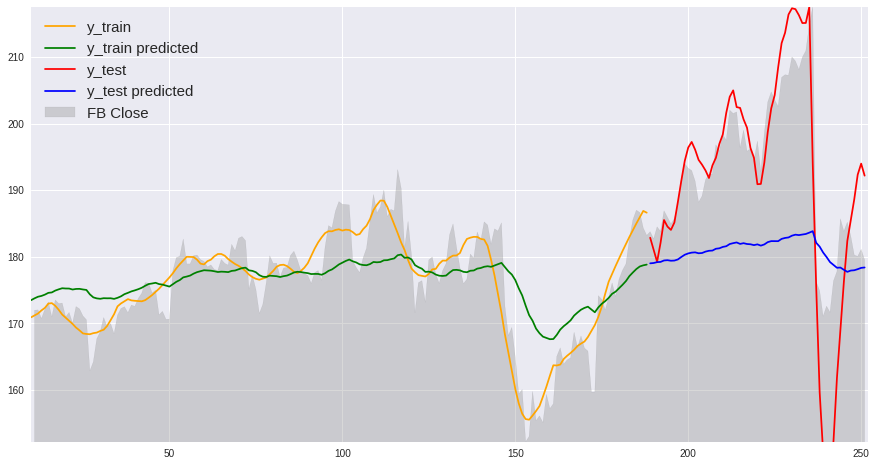

Buy
Hold:  -2.82%
Trade: -8.70%


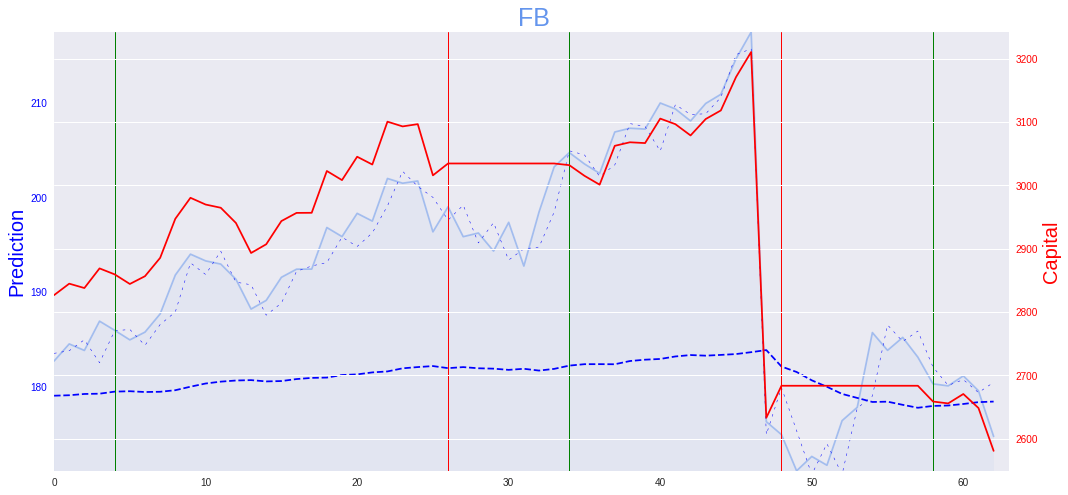

In [0]:
# MU = Stock('MU', start = '1y')
# WB = Stock('WB', start = '1y')
# AMZN = Stock('AMZN', start = '1y')
# GOOG = Stock('GOOG', start = '1y')
# CRSP = Stock('CRSP', start = '1y')
# FB = Stock('FB', start = '1y')

stock = FB

seed = int(random.random()*100)
np.random.seed(8)

window = 10
split = 0.75
epochs = 1
batch_size = 1

# Initialize portlofio
munniez = 1000
shares = 10
buy = 1
sell = 1

data = stock.data.copy()

# ---------------------------- smoothing function ------------------------------
def smoothed(price, fit):
  
    x = range(len(data[price]))
    y = data[price].values
    
    if fit == 'spline':
        tck, _ = splprep([x,y])
        x2, y2 = splev(np.linspace(0,1,len(y)), tck)

    elif fit == 'savgol':
        x2 = x
        y2 = savgol_filter(y, 21, 2, mode = 'interp')
    
    return x2, y2

xO, data['Open Smoothed'] = smoothed('Open', 'savgol')
xC, data['Close Smoothed'] = smoothed('Close', 'savgol')

t = []
w = int(len(data)*split)

t = list(savgol_filter(data['Close'][:w].values, 21, 2, mode = 'interp'))

for i in range(w,len(data)+1):
  
    temp = savgol_filter(data['Close'].values[:i], 21, 2, mode = 'interp')
    pts = temp[-20:]
    z = np.polyfit(range(i-20, i), pts, 3)
    f = np.poly1d(z)
    t.append(f(i+1))
    
t = t[1:]
data['Tomorrow'] = t

  
xC = range(len(data))

# ------------------------------------------------------------------------------

# tomorrow_predict_data = data[['Open Smoothed', 'Close Smoothed']][- window - 1:]

# Predict tomorrow's closing price
# data['Tomorrow'] = pd.ewma(data['Close'], 5).shift(-1)
# data['Tomorrow'] = data['Close Smoothed'].shift(-1)

# # Only keep Open, Close, and Tomorrow columns
data = data[['Open', 'Close', 'Tomorrow']]

# # tomorrow_predict_data = data.iloc[-window - 2:]
# # data.dropna(inplace = True)
# data.fillna(method='ffill', inplace = True)

# Shift the column to be predicted to the end
data = data[list(data.columns.drop('Tomorrow')) + ['Tomorrow']]

# Get training and test data
scaler = MinMaxScaler()

train_data, test_data,\
scaled_train_data, scaled_test_data,\
X_train, y_train, X_test, y_test = prepare_data(data, scaler, split, window)

print('Data shape: ', data.shape)
print('Train data : ', train_data.shape)
print('Test data : ', test_data.shape)
print('X_train :', X_train.shape)
print('y_train :', y_train.shape)
print('X_test  :', X_test.shape)
print('y_test  :', y_test.shape)
print()

# Create model
model = create_model(X_train, 'LSTM', window, 1)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 1)

# Get predictions
train_predictions = model.predict(X_train, batch_size = batch_size)
test_predictions = model.predict(X_test, batch_size = batch_size)

# Rescale data back
train_y_hat, test_y_hat = rescale(scaler, window,
                                  scaled_train_data, scaled_test_data,
                                  train_predictions, test_predictions)

# Plot predictions
plot_prediction(stock, 'price', train_data, test_data, train_y_hat,
                test_y_hat, y_train, window, xC)

# Trade
trade(stock, test_data, test_y_hat, munniez, shares, buy, sell)


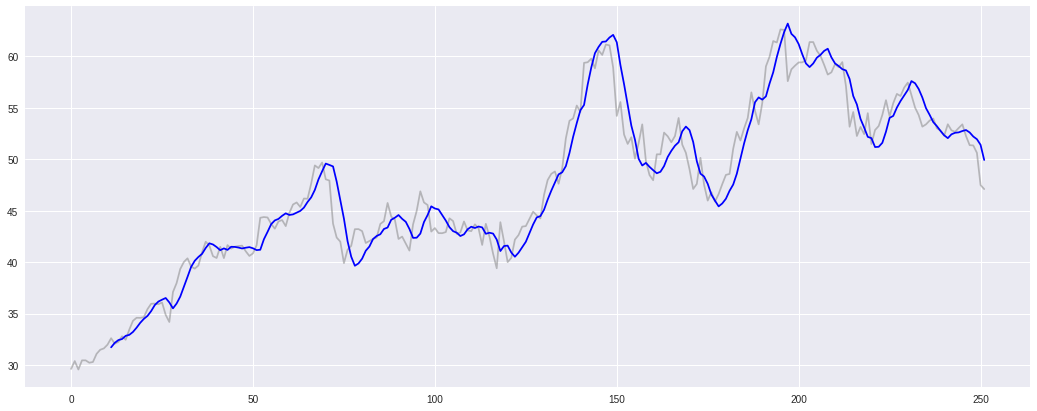

In [0]:
x = range(len(stock.data['Close']))
y = stock.data['Close'].values

# y2 = savgol_filter(y[:50], 21, 2, mode = 'interp')
# y3 = savgol_filter(y[:100], 21, 2, mode = 'interp')
# y4 = savgol_filter(y[:151], 21, 2, mode = 'interp')
# y5 = savgol_filter(y[:200], 21, 2, mode = 'interp')

# plt.figure(figsize = (20,15))
# plt.plot(y, 'grey', linewidth = 4, alpha = 0.3)
# plt.plot(y2, 'r', linewidth = 3, alpha = 0.7)
# plt.plot(y3, 'orange', linewidth = 2)
# plt.plot(y4, 'g', linewidth = 1)
# plt.plot(y5, 'black', linewidth = 0.5)
# plt.show()
w = 11

s = []
for i in range(w,len(x)):
  s.append(savgol_filter(y[:i], w, 1, mode = 'interp')[-1])
  
plt.figure(figsize = (18,7))  
plt.plot(y, 'grey', alpha = 0.5)  
plt.plot([np.nan]*w +s, 'b')
plt.show()


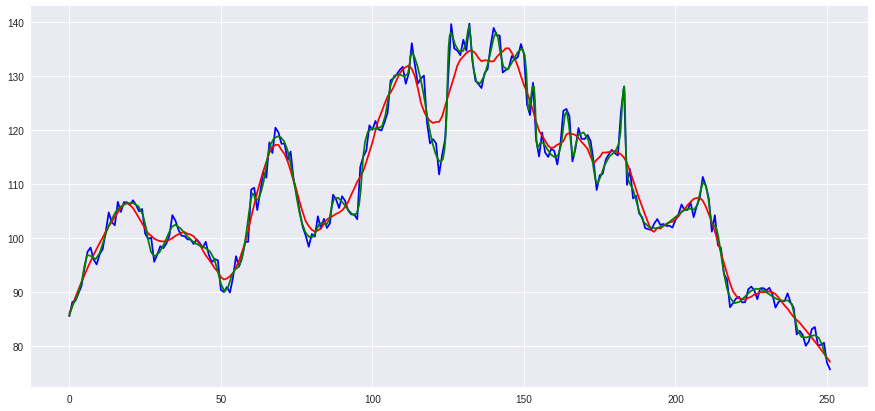

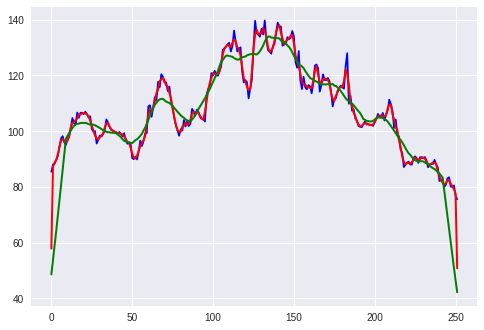

In [0]:
y = stock.data['Close'].values
x = range(len(y))

from scipy.signal import savgol_filter
yhat = savgol_filter(y, 21, 2, mode = 'interp')

plt.figure(figsize = (15,7))
plt.plot(y, 'b')
plt.plot(yhat, 'r')
plt.plot(xC[:-1], data['Close Smoothed'].values, 'g')
plt.show()


def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(x, y,'b')
plt.plot(x, smooth(y,3), 'r-', lw=2)
plt.plot(x, smooth(y,19), 'g-', lw=2)
plt.show()

## LSTM

In [0]:
# model = Sequential()
# model.add(LSTM(input_shape = (None, X_train.shape[-1]), units = window, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(128, return_sequences = False))
# model.add(Dropout(0.2))
# model.add(Dense(units = 1))
# model.add(Activation('linear'))

# model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# model.fit(X_train, 
#           y_train, 
#           batch_size = batch_size,
#           epochs = epochs,
#           verbose = 1
#          )

In [0]:
def create_model(X_train, model_name='LSTM', window = 25, activation='linear', time_ahead=1):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(window, input_shape=(None, X_train.shape[-1])))
    elif model_name == 'BiLSTM':
        model.add(Bidirectional(LSTM(window), input_shape=(None, X_train.shape[-1])))
    elif model_name == 'GRU':
        model.add(GRU(window, input_shape=(None, X_train.shape[-1])))
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model

model = create_model(X_train, 'LSTM', window, 1)
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 1)

Epoch 1/10
162/162 [==============================] - 8s 49ms/step - loss: 0.0288
Epoch 2/10
162/162 [==============================] - 3s 18ms/step - loss: 0.0103
Epoch 3/10
162/162 [==============================] - 3s 17ms/step - loss: 0.0076
Epoch 4/10
162/162 [==============================] - 3s 19ms/step - loss: 0.0061
Epoch 5/10
162/162 [==============================] - 3s 18ms/step - loss: 0.0051
Epoch 6/10
162/162 [==============================] - 3s 19ms/step - loss: 0.0043
Epoch 7/10
162/162 [==============================] - 3s 18ms/step - loss: 0.0036
Epoch 8/10
162/162 [==============================] - 3s 18ms/step - loss: 0.0033
Epoch 9/10
162/162 [==============================] - 3s 18ms/step - loss: 0.0030
Epoch 10/10
162/162 [==============================] - 3s 18ms/step - loss: 0.0025


In [0]:
train_predictions = model.predict(X_train, batch_size = batch_size)
test_predictions = model.predict(X_test, batch_size = batch_size)

def rescale(scaler, train_predictions, test_predictions, scaled_train_data, scaled_test_data, window):
  joined_trained = np.hstack((np.array(scaled_train_data[window:, :-1]), train_predictions))
  joined_test = np.hstack((np.array(scaled_test_data[window:, :-1]), test_predictions))
  train_y_hat = scaler.inverse_transform(joined_trained)[:, -1]
  test_y_hat = scaler.inverse_transform(joined_test)[:, -1]
  
  return train_y_hat, test_y_hat
  
train_y_hat, test_y_hat = rescale(scaler, train_predictions, test_predictions, scaled_train_data, scaled_test_data, window)

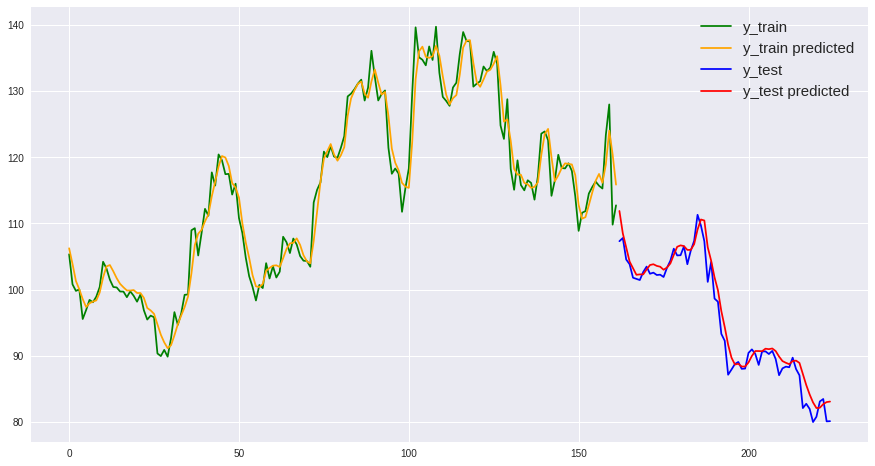

In [0]:
def plot_prediction(prediction):

  plt.figure(figsize = (15,8))

  if prediction == 'price':
    plt.plot(np.array(train_data.as_matrix()[window:, -1]), 'g', label = 'y_train')
    plt.plot(train_y_hat, 'orange', label = 'y_train predicted')
    plt.plot(([np.nan] * len(y_train)) + list(test_data.as_matrix()[window:, -1]), 'b', label = 'y_test')
    plt.plot(([np.nan] * len(y_train)) + list(test_y_hat), 'r', label = 'y_test predicted')

  elif prediction == 'change':

    trainS = np.cumsum(train_data.as_matrix()[window:])
    testS = np.cumsum(test_data.as_matrix()[window:])
    trainSP = np.round(np.cumsum(train_y_hat))
    testSP = np.round(np.cumsum(test_y_hat))
    
    plt.plot(trainS, 'g')
    plt.plot(trainSP, 'orange')
    plt.plot(([np.nan] * len(y_train)) + list(i + trainS[-1] for i in testS), 'b')
    plt.plot(([np.nan] * len(y_train)) + list(i + trainSP[-1] for i in testSP), 'r')

  plt.legend(fontsize = 15)
  plt.show()

plot_prediction('price')

Hold:  -25.34%
Trade: 8.23%


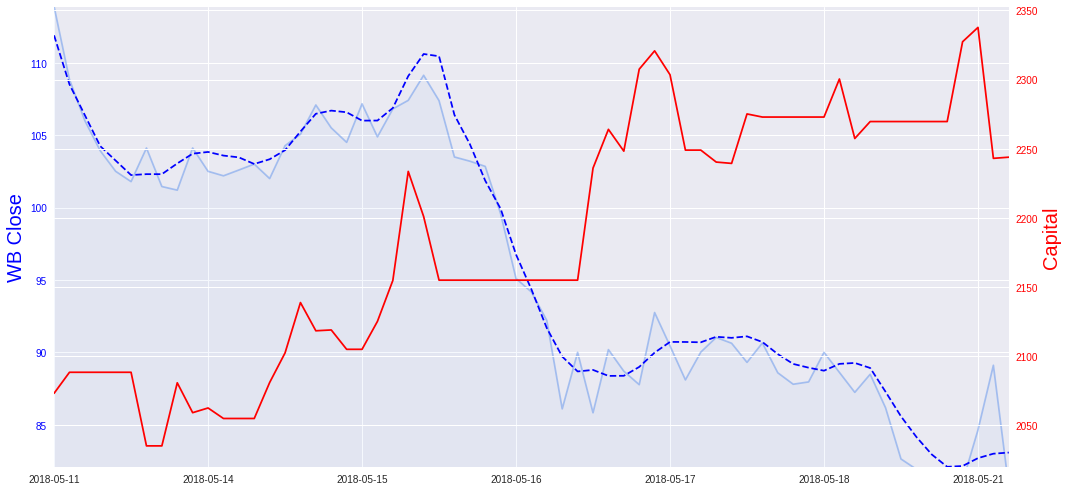

In [0]:
munniez = 1000
shares = 10
buy = 1
sell = 1

o = np.array(data['Open'].values)[-len(y_test):]
c = np.array(data['Close'].values)[-len(y_test):]
actual = np.array(test_data)[window:,0]
dates = data.index[-len(y_test):]

capital = [round(munniez + shares * c[0], 2)]
y_hat = test_y_hat

notes = False

  
for i in range(1, len(y_hat)):
  
  # buy some if today is predicted to close higher
  if y_hat[i] > y_hat[i-1]:
    if munniez*buy >= o[i]:
      bought = munniez*buy // o[i]
      munniez -= o[i] * bought
      munniez = round(munniez, 2)
      shares += bought
      if notes:
        print(dates[i].date(), 'Today: ', round(y_hat[i], 2),
              '. Yesterday: ', round(y_hat[i-1], 2),
              '. Bought ', bought, 'for $', round(o[i], 2),
              '. Total ', round(munniez, 2),
              '. Capital ', round(munniez + shares*o[i], 2))
      
  # sell some if today is predicted to close lower
  else:
    if shares > 0:
      sold = int(shares*sell)
      munniez += sold * o[i]
      shares -= sold
      if notes:
        print(dates[i].date(), 'Today: ', round(y_hat[i], 2),
              '. Yesterday: ', round(y_hat[i-1], 2),
              '. Sold ', sold, 'for $', round(o[i], 2),
              '. Total ', round(munniez, 2),
              '. Capital ', round(munniez + shares*o[i], 2))
      
  capital.append(round(munniez + shares * c[i], 2))

print('Hold: ', "{:.2%}".format((c[-1]-c[0])/c[0]))
print('Trade:', "{:.2%}".format((capital[-1]-capital[0])/capital[0]))
  
  
fig, ax1 = plt.subplots(figsize=(15,7))

ax1.plot(actual, 'cornflowerblue', alpha = 0.5)
ax1.set_ylabel(str(stock.stock) + ' Close', color='b', fontsize = 20)
ax1.set_xticklabels([d.date() for d in dates])
ax1.tick_params('y', colors='b')
ax1.set_xlim([0,len(actual) - 1])
ax1.set_ylim([min(y_hat), max(actual)])

ax1.fill_between(range(len(actual)), actual, color="cornflowerblue", alpha=0.06)

ax1.plot(y_hat, 'b--')

ax2 = ax1.twinx()
ax2.plot(capital, 'r')
ax2.set_ylabel('Capital', color='r', fontsize = 20)
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

## ALPHA VANTAGE

In [0]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='2RO3MQ9ANCPL05BD')

# ------------------ ALPHA VANTAGE ------------------------

class Stock:
  def __init__(self, stock = 'GOOG', interval = 'M'):

    self.stock = stock
    self.interval = interval

    if interval in ['I', 'i', 'intraday']: data, _ = ts.get_intraday(self.stock)
    elif interval in ['D', 'd', 'daily']: data, _ = ts.get_daily(self.stock)
    elif interval in ['W', 'w', 'weekly']: data, _ = ts.get_weekly(self.stock)
    elif interval in ['M', 'm', 'monthly']: data, _ = ts.get_monthly(self.stock)
    else: raise ValueError('Please pick intraday (I), daily (D), weekly (W), or monthly (M)')
    
    data = pd.DataFrame.from_dict(data, orient='index').reset_index()
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data.set_index('Date', inplace=True)
    del data.index.name
    
    self.data = data
      
  def get_EWMA(self, time = 'Close', span = 2):
      predicted = pd.ewma(self.data[time], span)
      self.data[str(time)+' EWMA'] = predicted.values

In [0]:
MU = Stock('MU', 'd')
print(MU.data.shape)

(100, 5)


## LSTM 5

In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout

seed = 8
np.random.seed(seed)
 
data = MU.data
split = int(0.75*len(data))

#currently doing prediction only for 1 step ahead
steps_to_predict = 1
 
data['Predict'] = MU.data['Close'].shift (-1)
data = pd.DataFrame(data).dropna()
       
cols = list(data.columns)[:-1]

train_data = np.array(data[:split])
test_data = np.array(data[split:])

x = data[cols]
y = data['Predict']

scaler = MinMaxScaler()

scaler.fit(train_data.reshape(-1,1))
train_data_scaled = scaler.transform(train_data.reshape(-1,1))
test_data_scaled = scaler.transform(test_data.reshape(-1,1))

x_train = train_data_scaled[:-1]
y_train = train_data_scaled[-1]
x_test = train_data_scaled[:-1]
y_test = train_data_scaled[-1]

window = 20
def unroll(data, window = 24):
    slices = []
    for i in range(len(data) - window):
        slices.append(data[i: i + window])
    return np.array(slices)
  
x_train = unroll(x_train, window)
y_train = y_train[-x_train.shape[0]:]
x_test = unroll(x_test, window)
y_test = y_train[-x_test.shape[0]:]
 
model = Sequential()
model.add(LSTM(1000, activation = 'tanh', inner_activation = 'hard_sigmoid' , input_shape =(len(cols), 1)))
model.add(Dropout(0.2))
model.add(Dense(output_dim =1, activation = 'linear'))
 
model.compile(loss = "mean_squared_error", optimizer = "adam")   
model.fit(x_train, y_train, batch_size = 16, nb_epoch = 10, shuffle = False)

score_train = model.evaluate(x_train, y_train, batch_size = 10)
score_test = model.evaluate(x_test, y_test, batch_size = 10)
print (" in train MSE = ", round(score_train ,4)) 
print (" in test MSE = ", score_test)

ValueError: ignored

In [0]:
pred1 = model.predict (x_test) 
pred1 = scaler.inverse_transform(np. array (pred1). reshape ((len( pred1), 1)))
     
prediction_data = pred1[-1]     
 
model.summary()
print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(x_test.shape))
print ("Actual output: {}".format(y_test.shape))
   
 
print("prediction data:")
print (prediction_data)
 
 
print("actual data")
x_test = scaler_x.inverse_transform (np. array (x_test). reshape ((len( x_test), len(cols))))
print (x_test)
 
 
plt.plot(pred1, label="predictions")
 
 
y_test = scaler_y.inverse_transform (np. array (y_test). reshape ((len( y_test), 1)))
plt.plot( [row[0] for row in y_test], label="actual")
 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
 
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)
 
ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
 
 
plt.show()

## LSTM 4

In [0]:
MU.data['Tomorrow'] = MU.data['Close'].shift(-1)
MU.data.dropna(inplace = True)
data = MU.data[['Close', 'Tomorrow']]

def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

# split into train and test sets
split = int(0.75*len(data))
train = data[:split]
test = data[split:]
 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
  
# reshape into X=t and Y=t+1
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
 
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
# create and fit the LSTM network
mdl = Sequential()
mdl.add(Dense(3, input_shape=(1, lags), activation='relu'))
mdl.add(LSTM(6, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 6s - loss: 0.1882
Epoch 2/10
 - 1s - loss: 0.1882
Epoch 3/10
 - 1s - loss: 0.1882
Epoch 4/10
 - 1s - loss: 0.1882
Epoch 5/10
 - 1s - loss: 0.1882
Epoch 6/10
 - 1s - loss: 0.1882
Epoch 7/10
 - 1s - loss: 0.1882
Epoch 8/10
 - 1s - loss: 0.1882
Epoch 9/10
 - 1s - loss: 0.1882
Epoch 10/10
 - 1s - loss: 0.1882


In [0]:
import math

# make predictions
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
print(type(y_train))
 
# invert transformation
# train_predict = scaler.inverse_transform(train_predict)
# y_train = scaler.inverse_transform([y_train])
# test_predict = scaler.inverse_transform(test_predict)
# y_test = scaler.inverse_transform([y_test])
 
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: {:.2f} RMSE'.format(test_score))

<class 'numpy.ndarray'>


TypeError: ignored

## LSTM 3

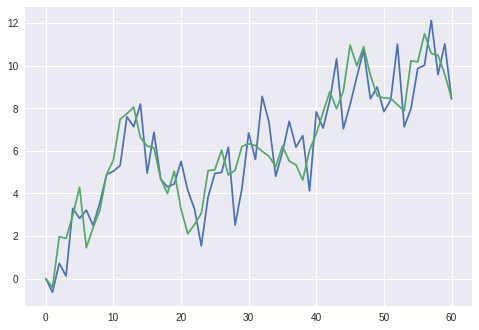

In [0]:
import keras.callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dense, Dropout
from keras.layers.recurrent import LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy.random as random


# look_back = 15
# predict = 1
# batch = 1
# layers = 32
# dropout = 0.3
# optimizer = 'adam'
# epochs = 3

LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1     #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once before updating gradients.
HIDDEN = 32
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

def coint_path(N,delta,sigma,PO):
    X = [PO]
    Y = [PO]
    for i in range(N):
      dX = random.randn()+delta*(Y[-1] - X[-1])
      X.append(X[-1]+dX)
      dY = random.randn()+sigma*(X[-1] - Y[-1])
      Y.append(Y[-1]+dY)
 
    return X,Y

#create artificial cointegrated series
X,Y = coint_path(60,0.9,0.1,0)
# X = MU.data['Close']
# Y = MU.data['Open']

plt.plot(X)
plt.plot(Y)
plt.show()
 
def prep_feature_data(X,Y):
    data = np.column_stack([X,Y])
    scaler = MinMaxScaler(feature_range=(-1,1))
    data = scaler.fit_transform(data)
 
    return data
 
#format features for the model into a multidimensional array
data = prep_feature_data(X,Y)

def window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW):
    examples = LOOKBACK_WINDOW
    y_examples = PREDICT_WINDOW
    nb_samples = len(data) - examples - y_examples #makes sure it can be split into lookback windows properly
 
    return nb_samples
 
#ensure it can be divided into the lookback window/batch size
nb_samples = window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW)

def input_features(nb_samples,LOOKBACK_WINDOW):
    input_list = [np.expand_dims(data[i:LOOKBACK_WINDOW+i,:], axis=0) for i in range(nb_samples)] #here nb_samples comes in handy
    input_mat = np.concatenate(input_list, axis=0)
 
    return input_mat
 
#format the features into the batch size
input_mat = input_features(nb_samples,LOOKBACK_WINDOW)

In [0]:
# def target_values(input_mat):
#   targets = []
#   for i in range(len(input_mat)):
#     X1 = input_mat[i].T[0]
#     X2 = input_mat[i].T[1]
#     beta = np.polyfit(X1,X2,1)[0] #the slope is calculated from each lookback window
#     X3 = X1[-1] - beta*X2[-1]
#     targets = np.append(targets, X3) 
#     targets = np.array(targets)

#   return targets

def target_values(input_mat):
  targets = np.array(X[LOOKBACK_WINDOW + PREDICT_WINDOW:] +[X[-1]])
  return targets
    
 
#format the targets into the batch size
targets = target_values(input_mat)


class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets):
    num_features = input_mat.shape[2] #this is the same as input dimension, used in describing batch_input_shape

    model = Sequential()

    model.add(LSTM(HIDDEN,batch_input_shape=(BATCH_SIZE,LOOKBACK_WINDOW,num_features)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1)) #the output is one dimensional

    model.compile(loss='mse',optimizer=OPTIMIZER)
    history = LossHistory()

    predictions,actuals,scores = [],[],[]

    assert(len(input_mat)==len(targets)) #checks each sample has a corresponding target value 

    for i in range(1,len(input_mat)):
        trainX = input_mat[0:i]
        trainY = targets[0:i]
        testX = input_mat[i].reshape(1,input_mat[0].shape[0],input_mat[0].shape[1]) #convert the input into 3 dimensional array
        testY = np.array([targets[i]]).reshape(1,1) #convert the target value into a 2 dimensional array

        #walk forward training, to predict the next timestep 
        #you can adjust the verbose parameter to 1 or 2 to watch the LSTM's progress 
        model.fit(trainX,trainY,nb_epoch=EPOCHS,batch_size=BATCH_SIZE,callbacks=[history],verbose=0)
        prediction = model.predict(testX,batch_size=BATCH_SIZE) 
        score = model.evaluate(testX,testY,batch_size=BATCH_SIZE,verbose=2)

        predictions.append(prediction[0][0])
#         actuals.append(targets[i])
        scores.append(score)

    return model,history,predictions,scores

In [0]:
def evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores):
    print(np.mean(scores[int(len(scores)*0.75):])) #since the latter predictions have been trained on more data, we take the average of the testing loss scores for the last quarter of predictions

    plt.figure(1)
    plt.plot(history.losses)
    plt.title('Loss History')
    plt.figure(2)
    plt.plot(scores)
    plt.title('Testing Loss')
    plt.figure(3)
    plt.plot(actuals,'b-',label='actual')
    plt.plot(predictions,'g-',label='prediction')
    plt.title('Basic LSTM')
    plt.legend()
    plt.grid('on')
    plt.show()
    
 
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1 #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once.
HIDDEN = 30
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 1
 
model,history,predictions,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,targets,scores)

AssertionError: ignored

In [0]:
batch_scores,batch_sizes = [],[]
for BATCH_SIZE in range(2,25):
    model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
    batch_scores.append(np.mean(scores[int(len(scores)*0.75):]))
    batch_sizes.append(BATCH_SIZE)

In [0]:
hidden_scores,hidden_sizes = [],[]
for HIDDEN in range(15,75):
    model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
    hidden_scores.append(np.mean(scores[int(len(scores)*0.75):]))
    hidden_sizes.append(HIDDEN)
    
epoch_scores,epoch_sizes = [],[]
for EPOCHS in range(1,20):
    model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
    epoch_scores.append(np.mean(scores[int(len(scores)*0.75):]))
    epoch_sizes.append(EPOCHS)
    
plt.plot(np.array(batch_sizes),np.array(batch_scores))
plt.title('Batch Size vs Test Loss')
plt.show()

## LSTM 2

In [0]:
s = MU.data

s['3'] = pd.ewma(s['Close'], 3)
s['10'] = pd.ewma(s['Close'], 10)
s['30'] = pd.ewma(s['Close'], 30)
s['Change'] = np.where(s['Close'].shift(-1) > s['Close'], 1, 0)

cols = list(s.columns)[:-1]
split = int(0.75*len(s))

X_train = s[:split][cols]
y_train = s[:split]['Change']
X_test = s[split:][cols]
y_test = s[split:]['Change']

train_data = s[:split]['Close']
test_data = s[split:]['Close']

scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1,1))
train_data = scaler.transform(train_data.reshape(-1,1))
test_data = scaler.transform(test_data.reshape(-1,1))

print(train_data.shape)
print(test_data.shape)

(378, 1)
(126, 1)


In [0]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

# def load_data(data, seq_len):
#     data = list(data.values)
#     print('==================================', len(data))
#     sequence_length = seq_len + 1
#     result = []
#     # create consecutive overlapping slices of data
#     for index in range(len(data) - sequence_length):
#         result.append(data[index: index + sequence_length])
   
#     result = np.array(result)

#     slice = int(0.75 * result.shape[0])
#     train = result[:slice]
#     test = result[slice:]
    
#     scaler = MinMaxScaler()
#     scaler.fit(train.reshape(-1,1))
#     train = scaler.transform(train.reshape(-1,1))
#     test = scaler.transform(test.reshape(-1,1))
    
#     x_train = train[:, :-1]
#     y_train = train[:, -1]
#     x_test = result[slice:, :-1]
#     y_test = result[slice:, -1]

# #     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# #     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

#     return [x_train, y_train, x_test, y_test]
  
# x_train, y_train, x_test, y_test = load_data(s, 15)
# print(x_train.shape, y_train.shape)

# # def normalise_windows(window_data):
# #     normalised_data = []
# #     for window in window_data:
# #         normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
# #         normalised_data.append(normalised_window)
# #     return normalised_data

data = MU.data
split = int(0.75*len(data))
window = 20
print(len(data))

def unroll(data, window = window):
    slices = []
    for i in range(len(data) - window):
        slices.append(data[i: i + window])
    return np.array(slices)

cols = list(data.columns)[:-1]
  
train_data = data[:split]
test_data = data[split - window:]

scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

X_train = np.array(scaled_train_data[:, :-1])
y_train = np.array(scaled_train_data[:, -1])
X_test = np.array(scaled_test_data[:, :-1])
y_test = np.array(scaled_test_data[:, -1])

X_train = unroll(X_train, window)
y_train = y_train[-X_train.shape[0]:]
X_test = unroll(X_test, window)
y_test = y_train[-X_test.shape[0]:]

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    print('----------------------------', int(len(data)/prediction_len))
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

504


In [0]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

    
global_start_time = time.time()
epochs  = 1
seq_len = 50

print('> Data Loaded. Compiling...')

model = build_model([1, 50, 100, 1])

model.fit(
    X_train,
    y_train,
    batch_size=100,
    nb_epoch=epochs,
    validation_split=0.05)

predictions = predict_sequences_multiple(model, X_test, seq_len, 10)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)
#predicted = lstm.predict_point_by_point(model, X_test)        

print('Training duration (s) : ', time.time() - global_start_time)
plot_results_multiple(predictions, y_test, 10)

> Data Loaded. Compiling...
> Compilation Time :  0.02616429328918457


ValueError: ignored

## LSTM (multiday)

In [0]:
X_train = s[:split][cols]
y_train = s[:split]['Change']
X_test = s[split:][cols]
y_test = s[split:]['Change']

train_data = s[:split]['Close']
test_data = s[split:]['Close']

scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1,1))
train_data = scaler.transform(train_data.reshape(-1,1))
test_data = scaler.transform(test_data.reshape(-1,1))

In [0]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.05300143 0.1303075  0.22225474 0.5505124  0.46120057]

	Output: [0.05300143 0.1303075  0.22225474 0.5610541  0.47086388]


Unrolled index 1
	Inputs:  [0.06793557 0.120937   0.22196198 0.5376281  0.46500733]

	Output: [0.05944366 0.120937   0.22401176 0.60439235 0.46881396]


Unrolled index 2
	Inputs:  [0.05944366 0.14026356 0.22401176 0.5616398  0.49633968]

	Output: [0.05944366 0.14114201 0.26090774 0.5610541  0.47086388]


Unrolled index 3
	Inputs:  [0.05651537 0.13821372 0.24685211 0.5610541  0.47086388]

	Output: [0.05358711 0.14114201 0.24685211 0.6641288  0.47701317]


Unrolled index 4
	Inputs:  [0.05358711 0.14348462 0.2620791  0.60439235 0.46881396]

	Output: [0.05358711 0.13674963 0.23045383 0.6641288  0.42957532]


In [0]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 30 # Number of time steps you look into the future.
batch_size = 20 # Number of samples in a batch
num_nodes = [1,200,150,1] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times


train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))
    
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           ) for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [0]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [0]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [0]:
all_mid_data = np.concatenate([train_data,test_data],axis=0)
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 30 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(len(train_data)).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:
      
      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized
Average loss at step 1: 2.268584
	Test MSE: 0.10155
	Finished Predictions
Average loss at step 2: 1.922354
	Test MSE: 0.07827
	Finished Predictions
Average loss at step 3: 1.183949
	Test MSE: 0.03623
	Finished Predictions
Average loss at step 4: 0.879483
	Test MSE: 0.03433
	Finished Predictions
Average loss at step 5: 0.861590
	Test MSE: 0.03467
	Finished Predictions
Average loss at step 6: 0.835102
	Test MSE: 0.03449
	Finished Predictions
Average loss at step 7: 0.845650
	Decreasing learning rate by 0.5
	Test MSE: 0.03651
	Finished Predictions
Average loss at step 8: 0.830575
	Test MSE: 0.03746
	Finished Predictions
Average loss at step 9: 0.859855
	Test MSE: 0.03803
	Finished Predictions
Average loss at step 10: 0.826234
	Decreasing learning rate by 0.5
	Test MSE: 0.03788
	Finished Predictions
Average loss at step 11: 0.817456
	Test MSE: 0.03766
	Finished Predictions
Average loss at step 12: 0.837980
	Test MSE: 0.03770
	Finished Predictions
Average loss at step 13: 0.8363

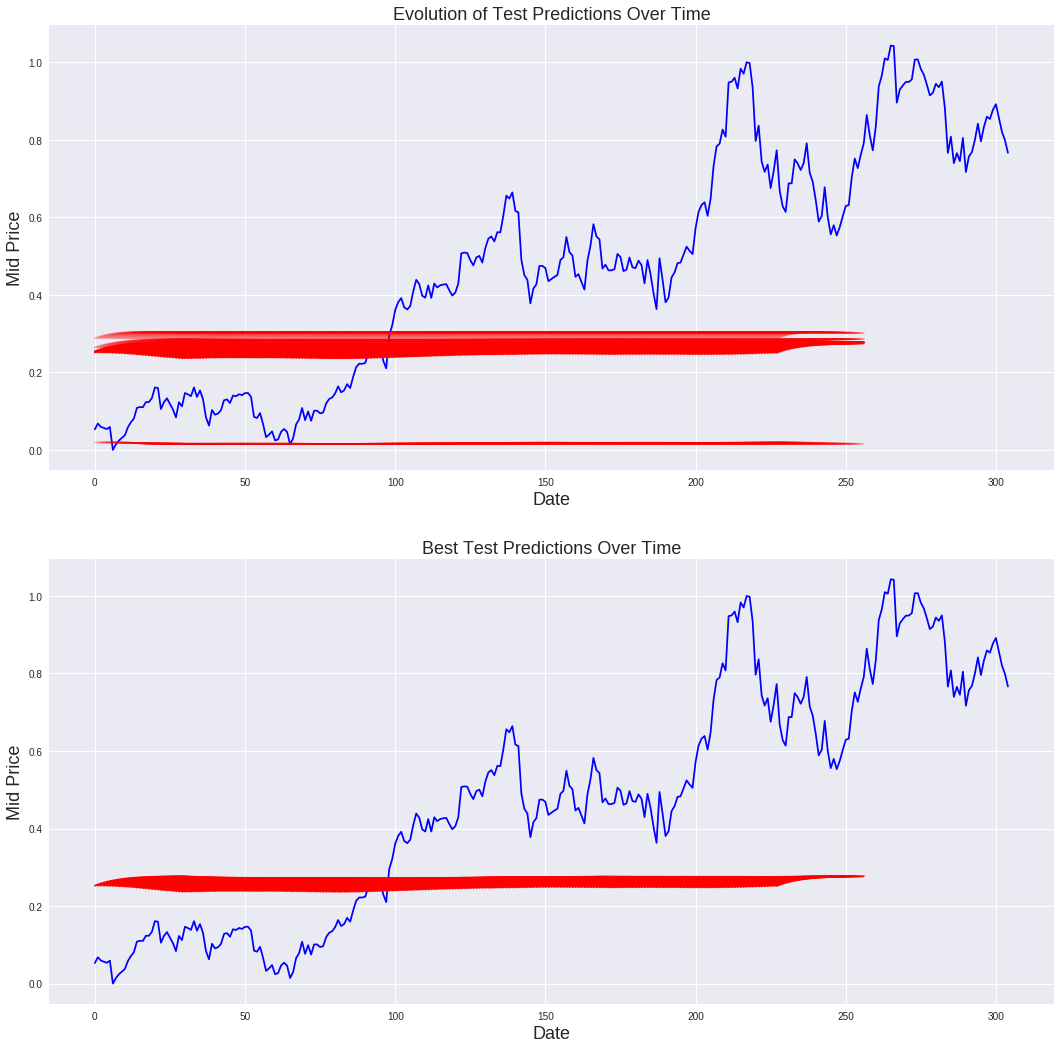

In [0]:
best_prediction_epoch = 21 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(s.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(s.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## GOOGLE

In [0]:
# ------------------ GOOGLE FINANCE ------------------------
class Stock:
  def __init__(self,
               stock = 'GOOG',
               period = '1Y',
               interval = 86400,
               market = 'NASDAQ'):

    self.stock = stock
    self._period = period
    self._interval = interval
    self.market = market

    data = get_price_data({'q': self.stock, 'p': self.period, 'i': self.interval, 'x': self.market})
    self.data = data

  @property
  def period(self):
      return self._period
    
  @property
  def interval(self):
      return self._interval
    
  @period.setter
  def period(self, val):
      self._period = val
      self.data = get_price_data({'q': self.stock, 'p': self.period, 'i': self.interval, 'x': self.market})
      
  @interval.setter
  def interval(self, val):
      self._interval = val
      self.data = get_price_data({'q': self.stock, 'p': self.period, 'i': self.interval, 'x': self.market})
      
  def get_EWMA(self, time = 'Close', span = 2):
      predicted = pd.ewma(self.data[time], span)
      self.data[str(time)+' EWMA'] = predicted.values

In [0]:
MU = Stock('MU', period = '14d', interval = 3600)
print(MU.period, MU.interval)
MU.period = '1Y'
MU.interval = 24*60*60
print(MU.period, MU.interval)

print(MU.data.head())
MU.get_EWMA(time = 'Open')
print(MU.data.head())

14d 3600
1Y 86400
Empty DataFrame
Columns: [Open, High, Low, Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Open EWMA]
Index: []


In [0]:
NASDAQ = Stock(stock = '.IXIC', period = '1Y', market ='INDEXNASDAQ')

fig, ax1 = plt.subplots(figsize=(18,10))

ax1.plot(NASDAQ.data['Close'], 'b')
ax1.set_ylabel('NASDAQ', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(MU.data['Close'], 'r')
ax2.set_ylabel('MU', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

ValueError: ignored

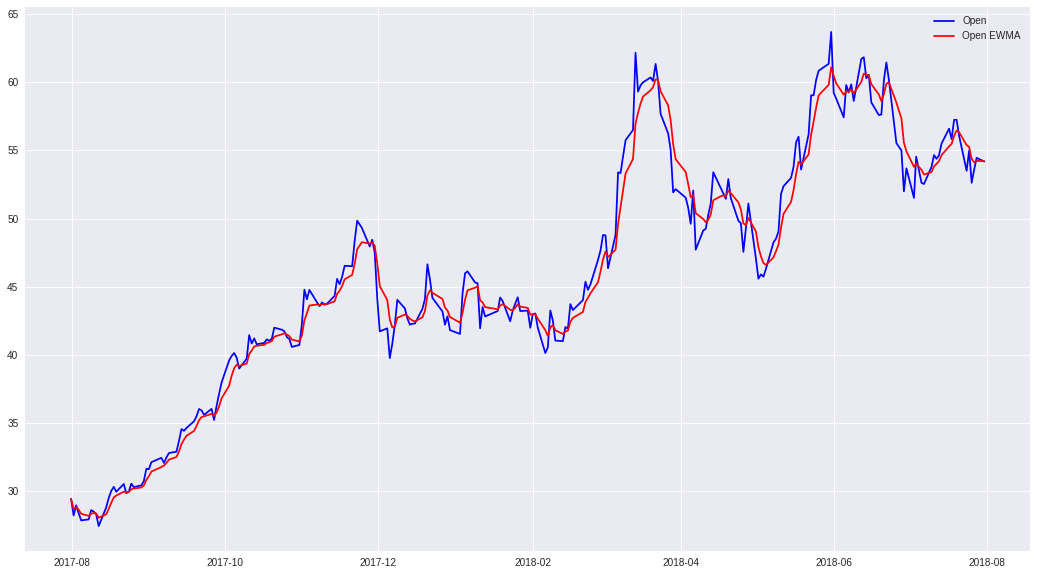

In [0]:
plt.figure(figsize=(18,10))
plt.plot(MU.data['Open'], 'b')
plt.plot(MU.data['Open EWMA'], 'r')
plt.legend()
plt.show()

In [0]:
s = Stock('MU', period = '1Y').data

s['3'] = pd.ewma(s['Close'], 3)
s['10'] = pd.ewma(s['Close'], 10)
s['30'] = pd.ewma(s['Close'], 30)
s['Change'] = np.where(s['Close'].shift(-1) > s['Close'], 1, 0)

cols = list(s.columns)[:-1]
split = int(0.75*len(s))

In [0]:
X_train = np.array(s[:split][cols])
y_train = np.array(s[:split]['Change'])
X_test = np.array(s[split:][cols])
y_test = np.array(s[split:]['Change'])

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)                         

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False);

clf.predict(X_test)

Using TensorFlow backend.


ValueError: ignored

In [0]:
X_train = s[:split][cols]
y_train = s[:split]['Change']
X_test = s[split:][cols]
y_test = s[split:]['Change']

def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 50.16% (0.82%)


In [0]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 49.63% (0.75%)


In [0]:
verbose=0

def create_model(optimizer='adam', init='uniform'):
    # create model
    if verbose: print("**Create model with optimizer: %s; init: %s" % (optimizer, init) )
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(4, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
  
run_gridsearch = False

if run_gridsearch:
    
    start_time = time.time()
    if verbose: print (time.strftime( "%H:%M:%S " + "GridSearch started ... " ) )
    optimizers = ['rmsprop', 'adam']
    inits = ['glorot_uniform', 'normal', 'uniform']
    epochs = [50, 100, 200, 400]
    batches = [5, 10, 20]
    
    model = KerasClassifier(build_fn=create_model, verbose=verbose)
    
    param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(X, Y)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    if verbose: 
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
        elapsed_time = time.time() - start_time  
        print ("Time elapsed: ",timedelta(seconds=elapsed_time))
        
    best_epochs = grid_result.best_params_['epochs']
    best_batch_size = grid_result.best_params_['batch_size']
    best_init = grid_result.best_params_['init']
    best_optimizer = grid_result.best_params_['optimizer']
    
else:
    # pre-selected paramters
    best_epochs = 200
    best_batch_size = 5
    best_init = 'glorot_uniform'
    best_optimizer = 'rmsprop'

In [0]:
X_train = pd.DataFrame(s[:split][cols])
y_train = pd.DataFrame(s[:split]['Change'])
X_test = np.array(s[split:][cols])
y_test = np.array(s[split:]['Change'])

# Create a classifier with best parameters
model_pred = KerasClassifier(build_fn=create_model, optimizer=best_optimizer, init=best_init, epochs=best_epochs, batch_size=best_batch_size, verbose=verbose)
model_pred.fit(X_train, y_train)

X_test = scaler.transform(X_test)

# Predict 'Survived'
prediction = model_pred.predict(X_test)

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 47.42% (5.97%)


In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

models = [
    RandomForestClassifier(n_estimators=100),
    MLPClassifier(),
]

for model in models:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(score)

0.5873015873015873
0.5873015873015873


In [0]:
from sklearn.naive_bayes import GaussianNB

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(X_train, y_train)
preds = gnb.predict(X_test)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, preds))

0.49206349206349204


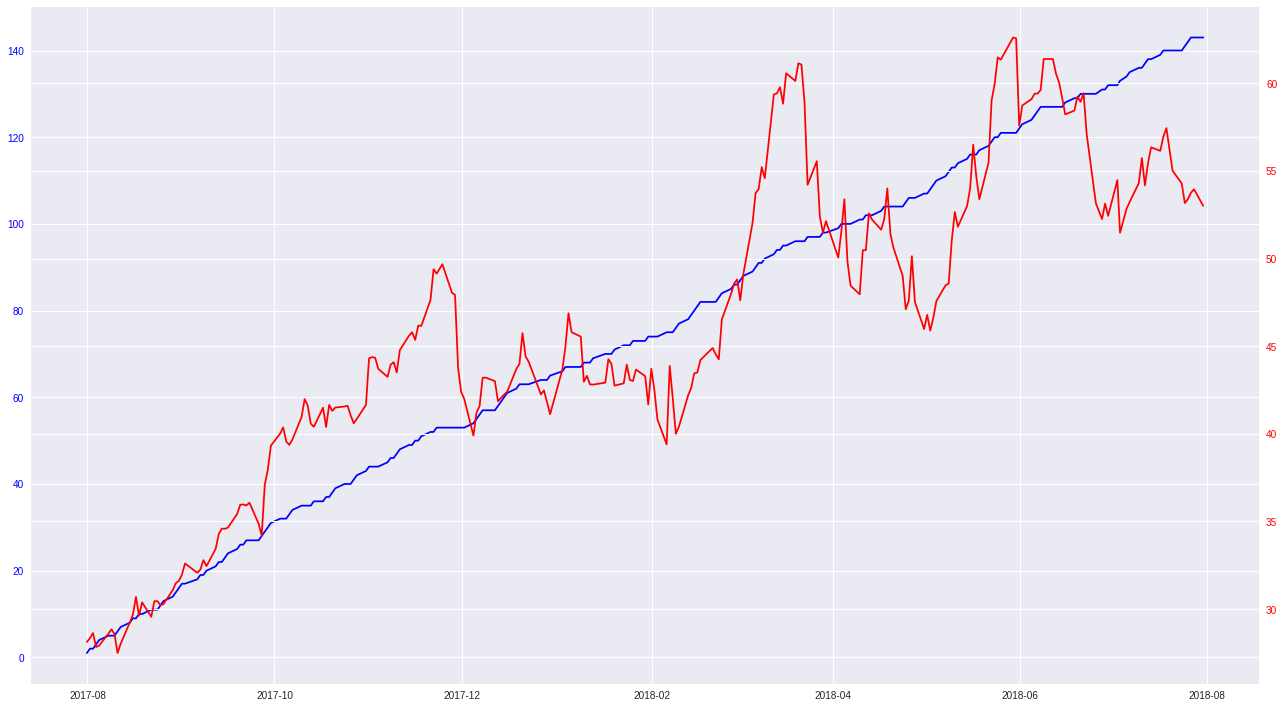

In [0]:
fig, ax1 = plt.subplots(figsize=(18,10))

ax1.plot(np.cumsum(s['Change']), 'b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(s['Close'], 'r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

## Twitter

In [0]:
# https://github.com/aleszu/reddit-sentiment-analysis/blob/master/r_subreddit.py
# https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
# http://www.storybench.org/how-to-scrape-reddit-with-python/
# personal use script
# gIJaBC5S_AcUTg
# secret	w6HZyL752-NXo6wkhE7o7BdFWiA

!pip install praw
!pip install textblob

    100% |████████████████████████████████| 102kB 592kB/s 


In [0]:
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob
 
class TwitterClient(object):
    '''
    Generic Twitter Class for sentiment analysis.
    '''
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
        # keys and tokens from the Twitter Dev Console
        consumer_key = 'XXXXXXXXXXXXXXXXXXXXXXXX'
        consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX'
        access_token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX'
        access_token_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXX'
 
        # attempt authentication
        try:
            # create OAuthHandler object
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            # set access token and secret
            self.auth.set_access_token(access_token, access_token_secret)
            # create tweepy API object to fetch tweets
            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")
 
    def clean_tweet(self, tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])
                                    |(\w+:\/\/\S+)", " ", tweet).split())
 
    def get_tweet_sentiment(self, tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(self.clean_tweet(tweet))
        # set sentiment
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
 
    def get_tweets(self, query, count = 10):
        '''
        Main function to fetch tweets and parse them.
        '''
        # empty list to store parsed tweets
        tweets = []
 
        try:
            # call twitter api to fetch tweets
            fetched_tweets = self.api.search(q = query, count = count)
 
            # parsing tweets one by one
            for tweet in fetched_tweets:
                # empty dictionary to store required params of a tweet
                parsed_tweet = {}
 
                # saving text of tweet
                parsed_tweet['text'] = tweet.text
                # saving sentiment of tweet
                parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text)
 
                # appending parsed tweet to tweets list
                if tweet.retweet_count > 0:
                    # if tweet has retweets, ensure that it is appended only once
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                else:
                    tweets.append(parsed_tweet)
 
            # return parsed tweets
            return tweets
 
        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))
 
def main():
    # creating object of TwitterClient Class
    api = TwitterClient()
    # calling function to get tweets
    tweets = api.get_tweets(query = 'Donald Drumpf', count = 200)
 
    # picking positive tweets from tweets
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
    # percentage of positive tweets
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets)))
    # picking negative tweets from tweets
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
    # percentage of negative tweets
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets)))
    # percentage of neutral tweets
    print("Neutral tweets percentage: {} % \
        ".format(100*len(tweets - ntweets - ptweets)/len(tweets)))
 
    # printing first 5 positive tweets
    print("\n\nPositive tweets:")
    for tweet in ptweets[:10]:
        print(tweet['text'])
 
    # printing first 5 negative tweets
    print("\n\nNegative tweets:")
    for tweet in ntweets[:10]:
        print(tweet['text'])
 
if __name__ == "__main__":
    # calling main function
    main()

## Other Stuff

In [0]:
m = []
data = list(MU.data['Close'].values)
for i in range(len(data)-14):
  m.append(data[i:i+14])
data = np.array(m)

s = int(0.75*len(data))

data_train = np.array(data[np.arange(0, s), :])
data_test = np.array(data[np.arange(s, len(data)), :])

X_train = data_train[:, :-1]
y_train = data_train[:, -1]
X_test = data_test[:, :-1]
y_test = data_test[:, -1]

print(X_train.shape)
print(y_train.shape)

from sklearn.linear_model import LinearRegression
logisticRegr = LinearRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

(178, 13)
(178,)
0.8181762934497185


0.5079365079365079


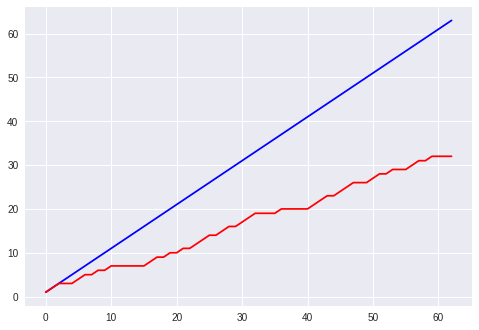

In [0]:

d = Stock('WB', period = '1Y')

df = pd.DataFrame()
df['Close'] = d.data['Close']
df['Open'] = d.data['Open']
df['3'] = EWMA(d.data['Close'], 3)
df['10'] = EWMA(d.data['Close'], 10)
df['30'] = EWMA(d.data['Close'], 30)
df['Change'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
# df['Tomorrow'] = list(df['Close'][1:].values)+[0]
df = df[:-1]
ar = np.array(df)


s = int(0.75*len(df))

data_train = np.array(ar[:s, :])
data_test = np.array(ar[s:, :])

X_train = data_train[:, :-1]
y_train = data_train[:, -1]
X_test = data_test[:, :-1]
y_test = data_test[:, -1]

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)
  
s = np.cumsum(df['Change'].values)
plt.plot(np.cumsum(predictions), 'b')
plt.plot(np.cumsum(y_test), 'r')
plt.show()

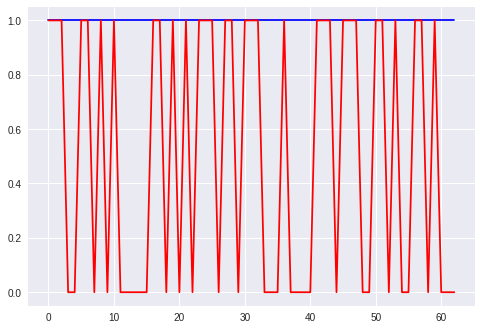

[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 0. 0. 1. 1. 0. 1.]


In [0]:
plt.plot(predictions, 'b')
plt.plot(y_test, 'r')
plt.show()
print(np.round(predictions[1:10],2))
print(y_test[:9])

In [0]:
munniez = 1000
shares = 50
buy = 0.5
sell = 0.5
o = list(d.data['Open'].values)[-len(y_test):]
c = list(d.data['Close'].values)[-len(y_test):]
capital = [munniez + shares*o[0]]

for i in range(len(predictions)-1):
  
#   if predictions[i] > predictions[i+1]:
#     if shares == 1:
#       sold = 1
#       munniez += sold*o[i+1]
#       shares = 0
#     elif shares > 1:
#       sold = int(shares*sell)
#       munniez += sold*o[i+1]
#       shares -= sold
#     else:
#       sold = 0
#     munniez -= sold * c[i+1]
#     shares += sold
      
  if predictions[i] < predictions[i+1]:
    if munniez*buy >= o[i+1]:
      bought = munniez*buy // o[i+1]
      munniez -= bought * o[i+1]
      shares += bought
    else:
      bought = 0
    munniez += bought*c[i+1]
    shares -= bought
      
  capital.append(munniez + shares*o[i+1])    

# o = list(MU.data['Open'].values)
# c = list(MU.data['Close'].values)
# capital = [munniez + shares * o[0]]

# for i in range(1, len(c)-1):
#   # SELL
#   if o[i] < c[i-1]:
#     if shares == 1:
#       sold = 1
#       munniez += sold*o[i]
#       shares = 0
#     elif shares > 1:
#       sold = int(shares*sell)
#       munniez += sold*o[i]
#       shares -= sold
#     else:
#       sold = 0
      
#   else:
#     if munniez*buy >= o[i]:
#       bought = munniez*buy // o[i]
#       munniez -= bought * o[i]
#       shares += bought
#     else:
#       bought = 0
#   capital.append(munniez + shares*o[i])    

-0.2077554716981131
-0.23404444444444442


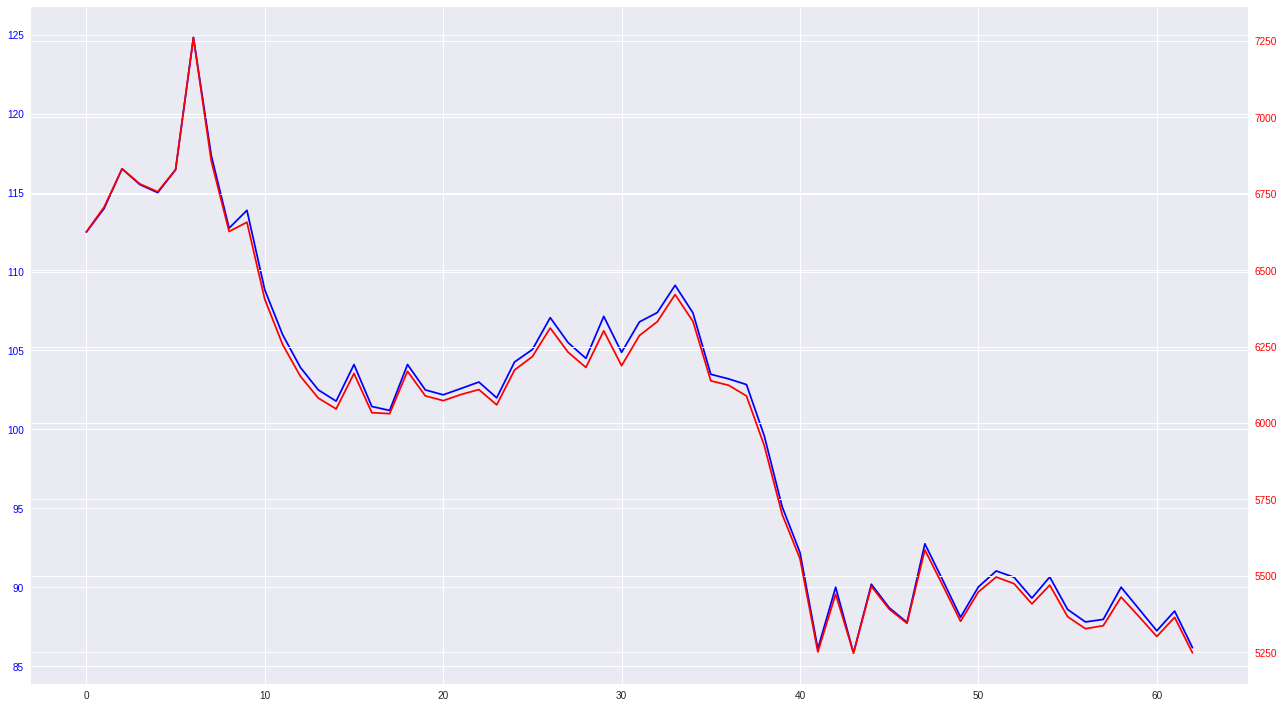

In [0]:
print((capital[-1]-capital[0])/capital[0])
print((o[-1]-o[0])/o[0])

fig, ax1 = plt.subplots(figsize=(18,10))

ax1.plot(o, 'b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(capital, 'r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [0]:
import random
random.seed(42)

def EWMA(data, span = 2):
  predicted = pd.ewma(data, span)
  return list(predicted.values)

def rsi(prices, rsi_span):
  ''' Relative Strength Index '''
  diff = [prices[1:][i] - prices[:-1][i] for i in range(len(prices)-1)]
  gains = [i if i > 0 else 0 for i in diff]
  losses = [i if i < 0 else 0 for i in diff]
  SMG = pd.ewma(pd.Series(gains), rsi_span).values
  SML = pd.ewma(pd.Series(losses), rsi_span).values
  
  RSI = []
  for i in range(len(SMG)):
    if SML[i] == 0: RSI.append(100)
    elif SMG[i] == 0: RSI.append(0)
    else: RSI.append(100 - 100/(1 + abs((SMG[i])/(SML[i]))))
  RSI[0] = 50
  return RSI

MU = Stock('MU')

dataset = MU.data[['Open', 'High', 'Low', 'Close']]
dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
# dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()
# dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()
# dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()
dataset['3day MA'] = EWMA(dataset['Close'], 1)
dataset['10day MA'] = EWMA(dataset['Close'], 3)
dataset['30day MA'] = EWMA(dataset['Close'], 10)
dataset['Std_dev']= dataset['Close'].rolling(5).std()
dataset['RSI'] = [50] + rsi(dataset['Close'].values, 9)
# dataset['Williams %R'] = talib.WILLR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)
dataset['Price_Rise'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)
dataset = dataset.dropna()

[]

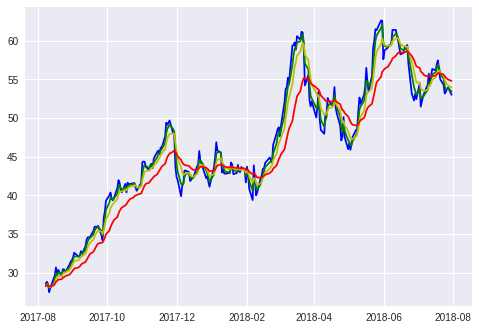

In [0]:
plt.plot(dataset['Close'], 'b')
plt.plot(dataset['3day MA'], 'g')
plt.plot(dataset['10day MA'], 'y')
plt.plot(dataset['30day MA'], 'r')
plt.plot()

In [0]:
X = dataset.iloc[:, 4:-1]
y = dataset.iloc[:, -1]

split = int(len(dataset)*0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

y_pred = classifier.predict(X_test)
y_pred = [int(round(i[0])) for i in y_pred]
print(y_pred)

# dataset['y_pred'] = np.NaN
# dataset.iloc[(len(dataset) - len(y_pred)):,-1:] = y_pred
# trade_dataset = dataset.dropna()



Epoch 1/100
196/196 [==============================] - 2s 9ms/step - loss: 0.2496 - acc: 0.5153
Epoch 2/100
196/196 [==============================] - 0s 177us/step - loss: 0.2457 - acc: 0.5714
Epoch 3/100
196/196 [==============================] - 0s 160us/step - loss: 0.2411 - acc: 0.5714
Epoch 4/100
196/196 [==============================] - 0s 166us/step - loss: 0.2387 - acc: 0.5561
Epoch 5/100
196/196 [==============================] - 0s 162us/step - loss: 0.2359 - acc: 0.5816
Epoch 6/100
196/196 [==============================] - 0s 165us/step - loss: 0.2371 - acc: 0.5867
Epoch 7/100
196/196 [==============================] - 0s 170us/step - loss: 0.2361 - acc: 0.6173
Epoch 8/100
196/196 [==============================] - 0s 194us/step - loss: 0.2329 - acc: 0.6071
Epoch 9/100
196/196 [==============================] - 0s 193us/step - loss: 0.2323 - acc: 0.6429
Epoch 10/100
196/196 [==============================] - 0s 195us/step - loss: 0.2314 - acc: 0.6224
Epoch 11/100
196/196 

196/196 [==============================] - 0s 220us/step - loss: 0.1987 - acc: 0.6990
Epoch 31/100
196/196 [==============================] - 0s 185us/step - loss: 0.1919 - acc: 0.7296
Epoch 32/100
196/196 [==============================] - 0s 209us/step - loss: 0.1888 - acc: 0.7194
Epoch 33/100
196/196 [==============================] - 0s 212us/step - loss: 0.1877 - acc: 0.7041
Epoch 34/100
196/196 [==============================] - 0s 203us/step - loss: 0.1848 - acc: 0.7347
Epoch 35/100
196/196 [==============================] - 0s 196us/step - loss: 0.1814 - acc: 0.7398
Epoch 36/100
196/196 [==============================] - 0s 192us/step - loss: 0.1827 - acc: 0.7398
Epoch 37/100
196/196 [==============================] - 0s 201us/step - loss: 0.1871 - acc: 0.7296
Epoch 38/100
196/196 [==============================] - 0s 198us/step - loss: 0.1825 - acc: 0.7194
Epoch 39/100
196/196 [==============================] - 0s 190us/step - loss: 0.1787 - acc: 0.7704
Epoch 40/100
196/196 [=

Epoch 60/100
196/196 [==============================] - 0s 185us/step - loss: 0.1356 - acc: 0.8163
Epoch 61/100
196/196 [==============================] - 0s 204us/step - loss: 0.1375 - acc: 0.8010
Epoch 62/100
196/196 [==============================] - 0s 195us/step - loss: 0.1357 - acc: 0.8163
Epoch 63/100
196/196 [==============================] - 0s 194us/step - loss: 0.1387 - acc: 0.8112
Epoch 64/100
196/196 [==============================] - 0s 230us/step - loss: 0.1316 - acc: 0.8214
Epoch 65/100
196/196 [==============================] - 0s 219us/step - loss: 0.1296 - acc: 0.8316
Epoch 66/100
196/196 [==============================] - 0s 199us/step - loss: 0.1316 - acc: 0.8112
Epoch 67/100
196/196 [==============================] - 0s 192us/step - loss: 0.1310 - acc: 0.8214
Epoch 68/100
196/196 [==============================] - 0s 184us/step - loss: 0.1321 - acc: 0.8316
Epoch 69/100
196/196 [==============================] - 0s 192us/step - loss: 0.1247 - acc: 0.8163
Epoch 70/1

196/196 [==============================] - 0s 192us/step - loss: 0.1052 - acc: 0.8673
Epoch 90/100
196/196 [==============================] - 0s 180us/step - loss: 0.1079 - acc: 0.8724
Epoch 91/100
196/196 [==============================] - 0s 209us/step - loss: 0.1045 - acc: 0.8571
Epoch 92/100
196/196 [==============================] - 0s 228us/step - loss: 0.1017 - acc: 0.8827
Epoch 93/100
196/196 [==============================] - 0s 212us/step - loss: 0.1000 - acc: 0.8724
Epoch 94/100
196/196 [==============================] - 0s 196us/step - loss: 0.1002 - acc: 0.8724
Epoch 95/100
196/196 [==============================] - 0s 196us/step - loss: 0.1017 - acc: 0.8520
Epoch 96/100
196/196 [==============================] - 0s 210us/step - loss: 0.0999 - acc: 0.8469
Epoch 97/100
196/196 [==============================] - 0s 200us/step - loss: 0.1023 - acc: 0.8673
Epoch 98/100
196/196 [==============================] - 0s 190us/step - loss: 0.0979 - acc: 0.8571
Epoch 99/100
196/196 [=

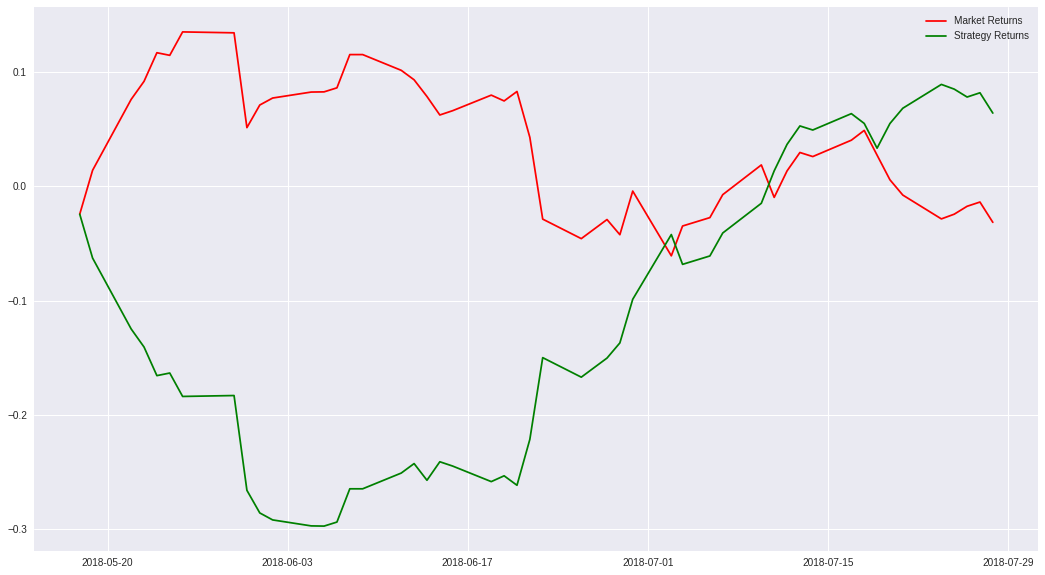

In [0]:
trade_dataset['Tomorrows Returns'] = 0.
trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)

trade_dataset['Strategy Returns'] = 0.
trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['Tomorrows Returns'], - trade_dataset['Tomorrows Returns'])

trade_dataset['Cumulative Market Returns'] = np.cumsum(trade_dataset['Tomorrows Returns'])
trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])

import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.plot(trade_dataset['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

In [0]:
# print(np.round(classifier.predict(X_test),2))
l = list(y_test.values)
p = [int(i[0]) for i in np.round(classifier.predict(X_test))]

t = [l[i] == p[i] for i in range(len(l))]
print(t)
c = t.count(True)
print(c)
print(c/len(l))

[False, False, False, False, False, True, False, True, False, False, False, False, False, True, True, True, True, True, False, True, False, False, True, False, True, True, False, True, True, True, True, False, True, True, True, True, True, True, False, True, False, False, True, True, True, False, False, True, False, False]
26
0.52


##Extra Tree Classifier

                 Open       High        Low      Close    Volume   Tomorrow  \
2017-08-11  27.440001  28.040001  26.850000  28.010000  23375900  29.240000   
2017-08-14  28.820000  29.360001  28.719999  29.240000  25254600  29.680000   
2017-08-15  29.500000  29.809999  29.139999  29.680000  23973600  30.690001   
2017-08-16  30.020000  30.860001  29.959999  30.690001  37879500  29.620001   
2017-08-17  30.320000  30.530001  29.610001  29.620001  26152500  30.379999   

                    3         10         30  Change  
2017-08-11  28.010000  28.010000  28.010000       1  
2017-08-14  28.712857  28.654286  28.635082       1  
2017-08-15  29.131081  29.029245  28.994869       1  
2017-08-16  29.701200  29.505536  29.439718       0  
2017-08-17  29.674584  29.532986  29.478177       1  


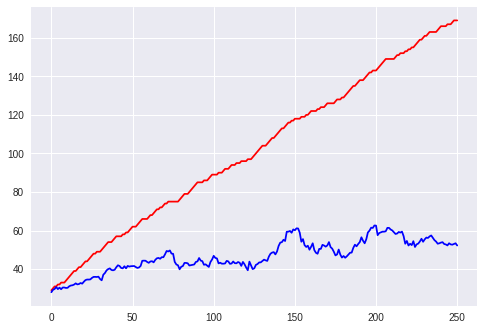

In [0]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import confusion_matrix, classification_report

print(data.head())
plt.plot([i+data['Close'].values[0] for i in np.cumsum(data['Change'].values)], 'r')
plt.plot(data['Close'].values, 'b')
plt.show()

In [0]:
train_data = data[:split]
test_data = data[split:]

X_train = np.array(train_data)[:, :-1]
y_train = np.array(train_data)[:, -1]
X_test = np.array(test_data)[:, :-1]
y_test = np.array(test_data)[:, -1]

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Extra Trees Classifier
# etc = ExtraTreesRegressor(n_estimators=600, max_depth=160, max_features='auto')
# model_etc = etc.fit(X_train,y_train)
# pred_etc = etc.predict(X_test)
# result_etc = model_etc.score(X_test, y_test)

etc_param_grid = {
     'max_features': ['auto', 'sqrt'], 
     'n_estimators':[250],
     'max_depth': [30]
}
etr = ExtraTreesRegressor(n_jobs=1, random_state=0)
model = GridSearchCV(estimator=etr, param_grid=etc_param_grid, n_jobs=1, cv=10)
model.fit(X_train, y_train)
pred = [round(i) for i in model.predict(X_test)]
print('Extra trees regression...')
print('Best Params:', model.best_params_)
print('Best CV Score:', model.best_score_)

y_pred = model.predict(X_test)

Extra trees regression...
Best Params: {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 250}
Best CV Score: 0.06185743595104657


In [0]:
print(confusion_matrix(y_test, pred))
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, pred))

[[27  2]
 [20 14]]
0.6713995943204868


188
63


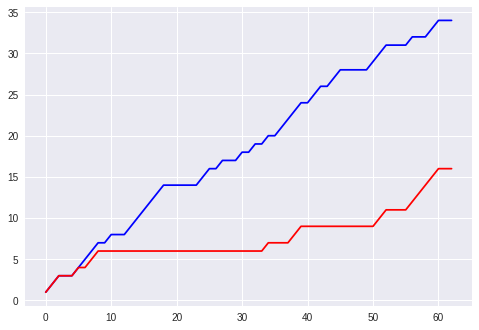

In [0]:
plt.plot(np.cumsum(y_test), 'b')
plt.plot(np.cumsum(pred), 'r')

## Reddit API

In [0]:
reddit = praw.Reddit(client_id='gIJaBC5S_AcUTg', \
                     client_secret='w6HZyL752-NXo6wkhE7o7BdFWiA', \
                     user_agent='Sentiment Analysis School Project', \
                     username='Solarmew', \
                     password='imsuper')

content = reddit.subreddit('stocks').search('$fb')

In [0]:
# topics_dict = {'id':[], "upvotes":[],  "title":[], "body":[], "top comment":[], "created": []}
dict = {'id':[], "upvotes":[],  "title":[], "body":[], "created": []}

for submission in content:
#     top_comment = [comment.body for comment in submission.comments][0]
#     print(top_comment)
    dict["id"].append(submission.id)
    dict["upvotes"].append(submission.ups)
    dict["title"].append(submission.title)
    dict["body"].append(submission.selftext)
#     topics_data['top comment'].append(top_comment)
    dict["created"].append(submission.created)
    
data = pd.DataFrame(dict)

In [0]:
data = data[['id', 'upvotes', 'title', 'body', 'created']]
data.head()

,id,upvotes,title,body,created
0,91w6rq,3,FB drop aftermarket,20% drop aftermarket - if I'm reading this rig...,1.532584e+09
1,91vl30,0,"Advice requested on AMZN, MSFT, GOOGL, AAPL, FB",I would like to diversify my portfolio and inv...,1.532580e+09
2,8kxazl,44,In what order do you sell off these stocks? $F...,"5 very talked about stocks in this sub, as wel...",1.526896e+09
3,8qc2ts,3,How to increase reward-risk ratio?,"Hi,\n\nNew trader here looking to swing trade ...",1.528773e+09
4,91w7la,107,How much are $fb puts expected to be increased...,1000% or less? I've had Netflix puts jump 400%...,1.532584e+09


In [0]:
def get_date(created):
    return dt.datetime.fromtimestamp(created).date()
  
_timestamp = data["created"].apply(get_date)
data = data.assign(Date = _timestamp)
data.sort_values('Date', inplace = True, ascending  = False)

data.drop('created', axis = 1, inplace = True)
print(data.head())

        id  upvotes                                              title  \
14  94s7xu        5  Would $FB ever be interested in acquiring Reddit?   
7   948flq       20                                        FB or MSFT?   
13  93tu5b       10                    [Discussion] Buying the Dip $FB   
24  937fao        0  FB, PYPL and SQ.... Both have taken a fall tod...   
28  934cwm        1  What are the future earnings report dates for ...   

                                                 body        Date  
14  Thinking about FB’s mission of bringing people...  2018-08-05  
7   If you could only choose one to invest in, whi...  2018-08-03  
13  I dont really understand why not to buy the di...  2018-08-02  
24  Since all of these stocks have taken a 2%-6% f...  2018-07-31  
28  I set an order to buy FB at 170 until 31 of Ju...  2018-07-30  


In [0]:
num = 4
                        
coms = sorted(reddit.submission(data['id'][num]).comments, key=lambda x: x.score, reverse = True)
tot = []

for comment in coms:
  sent = analyzer.polarity_scores(comment.body)
  tot.append(sent['compound'])
  print(comment.score, ': ', sent['compound'], '- ', comment.body)
  print('-'*150)
 
print(analyzer.polarity_scores(data['title'][num])['compound'], data['title'][num])
print(analyzer.polarity_scores(data['body'][num])['compound'], data['body'][num])
print(np.mean(tot[:3]))

146 :  -0.3182 -  If you don't sell them at open tomorrow you nuts.
------------------------------------------------------------------------------------------------------------------------------------------------------
96 :  0.5709 -  Dude sell at open. Fucking congrats. 
------------------------------------------------------------------------------------------------------------------------------------------------------
48 :  -0.3252 -  Post position or is not true 
------------------------------------------------------------------------------------------------------------------------------------------------------
44 :  0.9231 -  Ur put option price depends what your option strike price is. 

A put contract at 200$ strike expire 27 Jul is currently 0.95$ and will be worth 25$ tmr. 

most contracts in-the-money would easily be 10 times. 

Bravo for having the guts to buy that much in puts when you haven't really figured out potential values. Have an amazing weekend on your new wealth.



In [0]:
analyzer = SIA()

def print_sentiment_ratings(sentence):
    sent = analyzer.polarity_scores(sentence)
    print("{} {}".format(sentence, sent))
    print(sent['compound'])
    
print_sentiment_ratings(data['body'][0])

for c in 

20% drop aftermarket - if I'm reading this right. Are you seeing this as an opportunity or indication of caution?  {'neg': 0.096, 'neu': 0.776, 'pos': 0.128, 'compound': 0.1779}
0.1779


## IeXFinance

In [0]:
!pip install iexfinance

In [0]:
from iexfinance import Stock
tsla = Stock('TSLA')
tsla.get_open()
tsla.get_price()

355.49

In [0]:
from iexfinance import get_historical_data
from datetime import datetime

start = datetime(2017, 2, 9)
end = datetime(2017, 5, 24)

df = get_historical_data("AAPL", start=start, end=end, output_format='pandas')
df.head()

,open,high,low,close,volume
date,,,,,
2017-02-09,128.6506,129.4275,128.1327,129.4031,28349859
2017-02-10,129.4422,129.9113,129.0415,129.1099,20065458
2017-02-13,130.0481,130.7712,129.7256,130.2533,23035421
2017-02-14,130.4292,132.0123,130.2142,131.9439,33226223
2017-02-15,132.4325,133.1654,131.5530,132.4227,35623100


In [0]:
from iexfinance import get_available_symbols

get_available_symbols(output_format='pandas')[:2]

[{'date': '2018-08-10',
  'iexId': '2',
  'isEnabled': True,
  'name': 'Agilent Technologies Inc.',
  'symbol': 'A',
  'type': 'cs'},
 {'date': '2018-08-10',
  'iexId': '12042',
  'isEnabled': True,
  'name': 'Alcoa Corporation',
  'symbol': 'AA',
  'type': 'cs'}]

In [0]:
import iexfinance
help(iexfinance.get_market_most_active())
# dir(iexfinance)

Help on list object:

class list(object)
 |  list() -> new empty list
 |  list(iterable) -> new list initialized from iterable's items
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iadd__(self, value, /)
 |      Implement self+=value.
 |  
 |  __imul__(self, value, /)
 |      Implement self*=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __le__(self, value, /

## Test

In [0]:
!pip install bokeh

import subprocess
import os
import sys
import glob
import json
import numpy as np
import time
from ast import literal_eval
import matplotlib.pyplot as plt
from bokeh.plotting import figure
from bokeh.io import show, export_svgs
from IPython.display import SVG, display


def get_number_processors():
    """Get the number of processors in a CPU.
    Returns:
        num (int): Number of processors.
    Examples:
        >>> get_number_processors()
        4
    """
    try:
        num = os.cpu_count()
    except Exception:
        import multiprocessing #force exception in case mutiprocessing is not installed
        num = multiprocessing.cpu_count()
    return num


def to_1dimension(df, step_size):
    X, y = [], []
    for i in range(len(df)-step_size-1):
        data = df[i:(i+step_size), 0]
        X.append(data)
        y.append(df[i + step_size, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    return X, y
     
    
def plot_series(values, xlabel=None, ylabel=None, color='b', legend=None):
    xx = np.arange(1, len(values) + 1, 1)
    plt.plot(xx, values, color, label=legend)
    plt.legend(loc = 'upper left')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    
def plot_series_prediction(true_values, train_predict, test_predict, time_ahead=1, title=None,
                           xlabel=None, ylabel=None, color=['green','red','blue'], legend=[None,None,None]):    
    TOOLS = 'pan,wheel_zoom,box_zoom,reset,save,box_select'
    #x axis
    xx = np.array(range(true_values.shape[0]))
    xx1 = np.array(range(time_ahead,len(train_predict)+time_ahead))
    xx2 = np.array(range(len(train_predict)+(time_ahead*2)+1,len(true_values)-1))
    
    #figure
    p = figure(title=title, tools=TOOLS)
    p.line(xx, true_values.squeeze(), legend=legend[0], line_color=color[0], line_width=2)
    p.line(xx1, train_predict.squeeze(), legend=legend[1], line_color=color[1], line_width=1)    
    p.line(xx2, test_predict.squeeze(), legend=legend[2], line_color=color[2], line_width=1)
    p.axis[0].axis_label = xlabel
    p.axis[1].axis_label = ylabel
    p.legend.location = "top_left"
    show(p)
    
    #save to svg so it is rendered on github
    p.output_backend = "svg"
#     export_svgs(p, filename=title + '_.svg')
#     display(SVG(title + '_.svg'))

import  os
import  sys
import math
from  sklearn.preprocessing  import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Bidirectional, LSTM, GRU
import tensorflow as tf
from bokeh.io import output_notebook

In [0]:
EPOCHS = 5
TEST_SIZE = 0.3
TIME_AHEAD = 1 #prediction step
BATCH_SIZE = 1
UNITS = 25

df = stock.data
df = df.drop(['Volume'], axis=1)
df.head()

,Open,High,Low,Close
2017-08-14,978.409973,985.500000,976.190002,983.299988
2017-08-15,988.900024,991.739990,982.000000,982.739990
2017-08-16,981.650024,986.460022,973.219971,978.179993
2017-08-17,977.840027,977.840027,960.320007,960.570007
2017-08-18,961.400024,965.429993,954.650024,958.469971


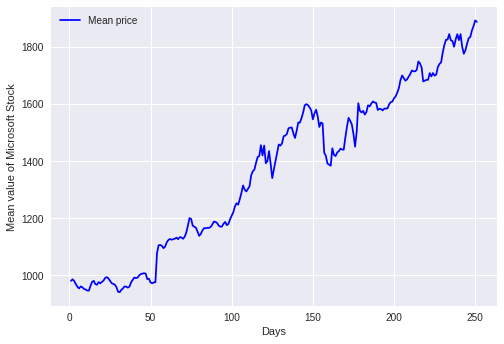

In [0]:
mean_price = df.mean(axis = 1)
plot_series(mean_price, xlabel='Days', ylabel='Mean value of Microsoft Stock', color='b', legend='Mean price')

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1)) #other typical scale values are -1,1
mean_price = scaler.fit_transform(np.reshape(mean_price.values, (len(mean_price),1)))

In [0]:
train, test = train_test_split(mean_price, test_size=TEST_SIZE, shuffle=False)
print(train.shape)
print(test.shape)

(175, 1)
(76, 1)


In [0]:
X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(173, 1, 1) (173,)
(74, 1, 1) (74,)


In [0]:
def create_symbol(model_name='LSTM', units=10, activation='linear', time_ahead=1):
    model = Sequential()
    if model_name == 'LSTM':
        model.add(LSTM(units, input_shape=(None, X_train.shape[-1])))
    elif model_name == 'BiLSTM':
        model.add(Bidirectional(LSTM(units), input_shape=(None, X_train.shape[-1])))
    elif model_name == 'GRU':
        model.add(GRU(units, input_shape=(None, X_train.shape[-1])))
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model

model = create_symbol(model_name='LSTM', units=UNITS, time_ahead=TIME_AHEAD)
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

In [0]:
y_test_invy_test_i  = scaler.inverse_transform([y_test])
mean_price_inv = scaler.inverse_transform(mean_price)

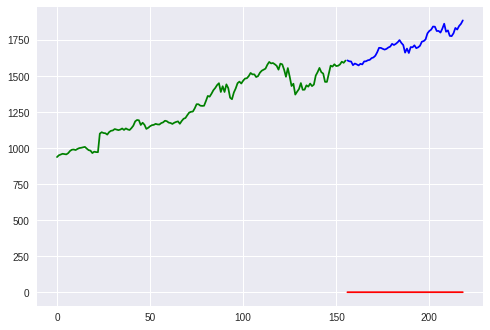

In [0]:
plt.plot(np.array(train_data.as_matrix()[window:, -1]), 'g')
plt.plot(([np.nan] * len(y_train)) + list(test_data.as_matrix()[window:, -1]), 'b')
plt.plot(([np.nan] * len(y_train)) + list(pred_test), 'r')
plt.show()

In [0]:
!pip install selenium

    100% |████████████████████████████████| 901kB 7.0MB/s 


In [0]:
pred_train = model.predict(X_train)
pred_train = scaler.inverse_transform(pred_train)
plot_series_prediction(mean_price_inv, pred_train, pred_test, time_ahead=TIME_AHEAD,
                       title='LSTM prediction', xlabel='Days', ylabel='Value of Microsoft Stock', 
                       legend=['True value','Training set','Test prediction'])

251
173
74
247


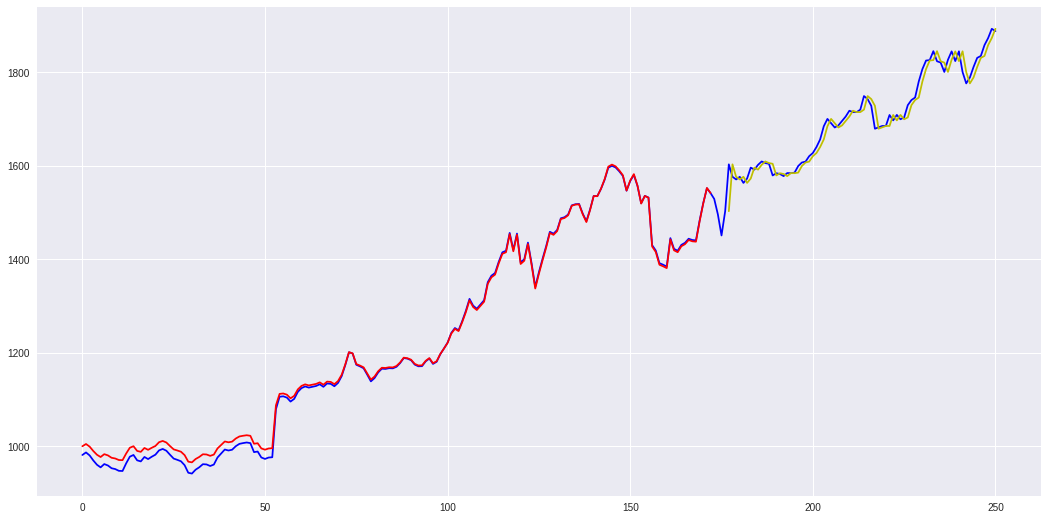

In [0]:
print(len(mean_price_inv))
print(len(pred_train))
print(len(y_test_inv[0]))
print(len(pred_train)+len(y_test_inv[0]))
plt.figure(figsize = (18,9))
plt.plot(mean_price_inv, 'b')
plt.plot([[np.nan]*(len(pred_train) + 4)][0] + list(y_test_inv[0]), 'y')
plt.plot(pred_train, 'r')
plt.show()

In [0]:
print(y_test_inv)

[[1502.72250375 1603.029999   1576.3924865  1570.66500875 1576.38000475
  1563.22750875 1572.62246675 1596.064972   1591.6950075  1602.
  1609.14996325 1605.72250375 1604.1925355  1579.235016   1583.97003175
  1582.340027   1577.84747325 1584.3775025  1584.1075135  1585.27749625
  1599.4299925  1606.9299925  1608.88000475 1620.48001125 1627.24249275
  1640.0975035  1656.335022   1684.60000625 1700.30749525 1690.96752925
  1681.889984   1686.36499025 1695.6950075  1705.38500975 1717.75250225
  1714.8399965  1714.8375245  1720.080017   1749.21749875 1742.7200015
  1728.29751575 1679.24252325 1682.09246825 1685.1424865  1685.1650085
  1708.63250725 1697.1075135  1708.8499755  1699.4874875  1703.39251725
  1729.715027   1740.64999375 1745.98748775 1780.32751475 1806.872528
  1825.20996075 1826.14001475 1845.26751725 1823.674988   1820.9024965
  1800.79998775 1826.90750125 1844.84750375 1824.0450135  1844.97503675
  1800.51748675 1776.26995825 1788.90750125 1811.41500875 1830.88250725
  183

## Backup stuff

In [0]:
def trade(data, test_data, test_y_hat, munniez, shares, buy, sell, notes = False):
    # initial values
    m0 = munniez
    s0 = shares
    
    # Open and Close test values for test time period
    o = np.array(data['Open'].values)[-len(test_y_hat) + 1:]
    c = np.array(data['Close'].values)[-len(test_y_hat) + 1:]
    
    # Actual closing values for test time period
    actual = np.array(test_data)[window:,3]
    predicted = test_y_hat
    dates = data.index[-len(test_y_hat):]

    capital = [round(munniez + shares * c[0], 2)]

    history = [0]
    
    for i in range(1, len(predicted)-1):
        hold = True
        # buy some if today is predicted to close higher
        if predicted[i] > predicted[i-1]:
            if munniez*buy >= o[i]:
                history.append(1)
                hold = False
                bought = munniez*buy // o[i]
                munniez -= o[i] * bought
                munniez = round(munniez, 2)
                shares += bought
                if notes:
                    print(dates[i].date(), 'Today: ', round(predicted[i], 2),
                          '. Yesterday: ', round(predicted[i-1], 2),
                          '. Bought ', bought, 'for $', round(o[i], 2),
                          '. Portfolio ', round(munniez, 2), shares,
                          '. Capital ', round(munniez + shares*c[i], 2))

        # sell some if today is predicted to close lower
        elif predicted[i] < predicted[i-1]:
            if shares > 0:
                history.append(-1)
                hold = False
                sold = int(shares*sell)
                munniez += sold * o[i]
                shares -= sold
                if notes:
                    print(dates[i].date(), 'Today: ', round(predicted[i], 2),
                          '. Yesterday: ', round(predicted[i-1], 2),
                          '. Sold ', sold, 'for $', round(o[i], 2),
                          '. Portfolio', round(munniez, 2),  shares,
                          '. Capital ', round(munniez + shares*c[i], 2))

        if hold:
            history.append(0)
            if notes:
                print(dates[i].date(), 'Today: ', round(predicted[1], 2),
                      '. Yesterday: ', round(predicted[i-1], 2),
                      '. ------ Hold ------ ',
                      '. Portfolio ', round(munniez, 2), shares,
                      '. Capital ', round(munniez + shares*c[i], 2))
              
        capital.append(round(munniez + shares * c[i], 2))

    i = (m0 + s0 * c[0])
    f = (m0 + s0 * c[-1])
    print('Hold: ', "{:.2%}".format((f - i)/i))
    print('Trade:', "{:.2%}".format((capital[-1]-capital[0])/capital[0]))


    fig, ax1 = plt.subplots(figsize=(15,7))
    fig.suptitle(str(stock.stock), fontsize = 25, color = 'cornflowerblue')
    
    ax1.plot(actual[1:], 'cornflowerblue', alpha = 0.5)
    ax1.set_ylabel('Prediction', color='b', fontsize = 20)
    ax1.set_xticklabels([d.date() for d in dates])
    ax1.tick_params('y', colors='b')
    ax1.set_xlim([0,len(actual) - 1])
    ax1.set_ylim([min([min(actual), min(predicted)]), max([max(actual), max(predicted)])])

    ax1.fill_between(range(len(actual)-1), actual[1:], color="cornflowerblue", alpha=0.06)

    ax1.plot(predicted[:-1], 'b--')

    ax2 = ax1.twinx()
    ax2.plot(capital, 'r')
    ax2.set_ylabel('Capital', color='r', fontsize = 20)
    ax2.tick_params('y', colors='r')
    
    # mark where selling and buying
    for i in range(len(history)):
        if history[i] > 0:
            ax1.axvline(x = i, color = 'green', linewidth = 1)
        elif history[i] < 0:
            ax1.axvline(x = i, color = 'red', linewidth = 1)

    fig.tight_layout()
    fig.subplots_adjust(top = 0.93)
    
    plt.show()